In [ ]:
!pip install -U gensim
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install pyLDAvis
!pip install python-Levenshtein
!pip install wordcloud

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
import sys

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt
%matplotlib inline

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis #don't skip this
pyLDAvis.enable_notebook()




# spacy for lemmatization
import spacy


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## NLTK Stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stopwords = open("stopwords.txt", 'r')
stopwords = [ w.strip() for w in stopwords.read().split('\n')]
symbols = ["'", '"', '“', '”', '`', '’', '.', ',', '-', '!', '?', ':', ';', '(', ')', '[', ']', '&', '0', '%', '...', '--','@','#','_']
stopwords = stop_words + stopwords + symbols



# load corpus
def load_corpus(file):
    documents = pd.read_csv(file)
    return documents

# Tokenize Sentences and simply clean       
def sent_to_tokens(doc):
    for word in doc:
        if word is not word.isalnum():
            word = re.sub('\S*@\S*\s?', '', word)  # remove emails
            #word = re.sub('\s+', ' ', word)  # remove newline chars
            #word = re.sub("\'", '', word)  # remove single quotes
            word = re.sub('#\S*', '', word) # remove hashtags
            word = re.sub(r"http\S+", "", word) # remove url
            word = re.sub('@\S*', '', word) #remove @users
            word = re.sub('_', ' ', word) #remove linked_word
            word = re.sub('temp', 'temperature', word)
            word = re.sub('gvmt', 'government', word)
            word = re.sub('govt', 'government', word)
            word = gensim.utils.simple_preprocess(str(word), deacc=True)
            yield(word)
        yield(word)

# !python3 -m spacy download en  # run in terminal once
def process_tokens(texts, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    Removed 'VERB' """
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


def tokens_to_bow(tokens, dictionary):
    return [dictionary.doc2bow(document) for document in tokens]

def fit_lda(tokens, number_of_topics, dictionary):
    return LdaModel(tokens_to_bow(tokens, dictionary), number_of_topics, dictionary)

# BOW
def ids_to_words(bow, dictionary):
    return [(dictionary.id2token[w], f) for w, f in bow]

def document_topics_matrix(tokens, dictionary):
    return [lda.get_document_topics(bow) for bow in tokens_to_bow(tokens, dictionary)]

def show_document_topics_matrix(dtm):
    for i, topics in enumerate(dtm):
        print(i, topics)


def topic_co_occurrence_matrix(dtm, min_weight=0.3):
    return [[t for t, w in topics if w >= min_weight] for topics in dtm]

def tcom_to_sentences(tcom):
    l=[]
    for tco in tcom:
        tco = ["T{}".format(t) for t in tco]
        tco.append('.')
        l.append(tco)
    return l


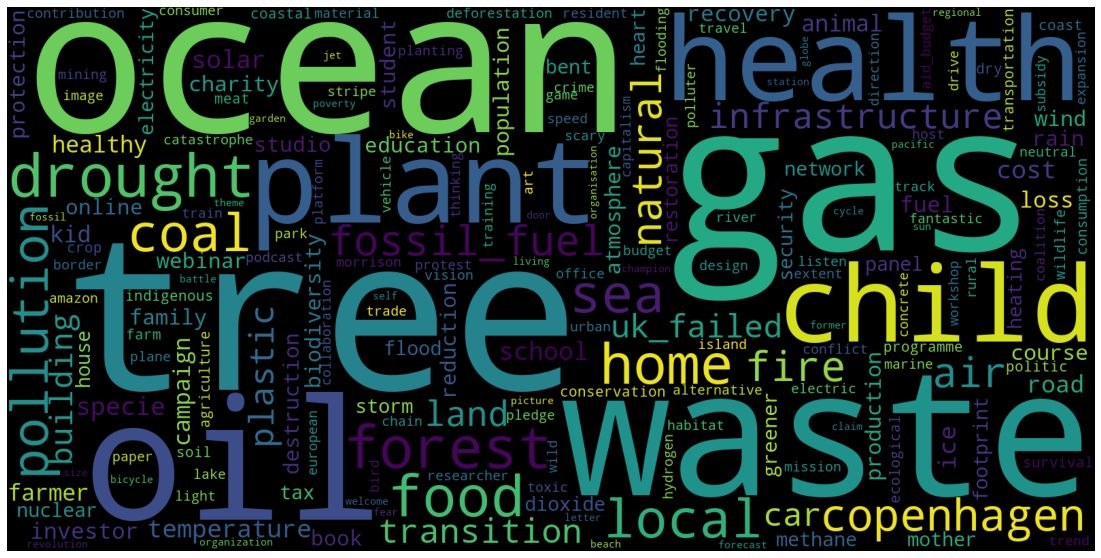

In [2]:
##main#########################################
corpus = load_corpus("keyword-tweets.csv")

# print(corpus.head)
# show_corpus(corpus)

# Convert to list and find Tokens
doc = corpus.content.values.tolist()
tokensW = list(sent_to_tokens(doc))

#print(tokensW)


# N-grams
## Build the bigram and trigram models
bigram = gensim.models.Phrases(tokensW, min_count=5, threshold=100) #higher threshold fewer phrases
trigram = gensim.models.phrases.Phrases(bigram[tokensW], threshold=100)

## Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

tokens = process_tokens(tokensW)

with open('tokens.txt', 'w') as filehandle:
    for listitem in tokens:
        filehandle.write('%s\n' % listitem)

from wordcloud import WordCloud
# word cloud

#define a function to plot word cloud
def plot_cloud(wordcloud):
    #set figure size
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    
#Generate word cloud

text = str(tokens)
text = re.sub("'","",text)
wordcloud = WordCloud(width=1600, height=800, collocations=False).generate(text)

plot_cloud(wordcloud)

#save image
wordcloud.to_file("wordcloud.png")

In [55]:
#lda model

### preset number of topics
num_topics = 40

dictionary = Dictionary(tokens)
lda = fit_lda(tokens, num_topics, dictionary)
#lda.save('model.gensim')

#pprint(lda.print_topics(num_topics = num_topics))

with open('topics.txt', 'w') as filehandle:
    for index, topic in lda.print_topics(num_topics = num_topics):
        filehandle.write('topic:{} \nWord {} \n'.format(index, topic))
        
# dtm
dtm = document_topics_matrix(tokens, dictionary)

#show_document_topics_matrix(dtm)

tcom = topic_co_occurrence_matrix(dtm, 0.3)
for i, tco in enumerate(tcom):
    print(i, tco)
dtm_df = pd.DataFrame(tcom)
#print(dtm_df)

dtm_df.to_csv('dtm_df.csv')


# transform topics into desired format - topic sentences
l=tcom_to_sentences(tcom)
outlst = [' '.join([str(c) for c in lst]) for lst in l]
#print("\n".join(outlst))
d="\n".join(outlst)

outFileName = "CD_input.txt"
outFile = open(outFileName, "w")
outFile.write(d)
outFile.close()


0 []
1 []
2 [13]
3 [13]
4 [7, 37]
5 [7, 37]
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 [11]
15 [11]
16 []
17 []
18 [37]
19 [37]
20 []
21 []
22 [31]
23 [31]
24 []
25 []
26 []
27 []
28 []
29 []
30 [2, 3]
31 [2, 3]
32 []
33 []
34 []
35 []
36 [11]
37 [11]
38 []
39 []
40 [0]
41 [0]
42 []
43 []
44 [5]
45 [5]
46 []
47 []
48 [24]
49 [24]
50 []
51 []
52 [16]
53 [16]
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 [20]
69 [20]
70 []
71 []
72 [12]
73 [12]
74 []
75 []
76 [21]
77 [21]
78 [32]
79 [32]
80 [31]
81 [31]
82 [37]
83 [37]
84 []
85 []
86 [20]
87 [20]
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 [33]
101 [33]
102 []
103 []
104 []
105 []
106 []
107 []
108 [32]
109 [32]
110 []
111 []
112 []
113 []
114 [15]
115 [15]
116 []
117 []
118 []
119 []
120 []
121 []
122 [20]
123 [20]
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 [14]
133 [14]
134 [39]
135 [39]
136 [7]
137 [7]
138 [16]
139 [16]
140 [13, 29]
141 [13, 

1238 [8]
1239 [8]
1240 []
1241 []
1242 []
1243 []
1244 []
1245 []
1246 []
1247 []
1248 []
1249 []
1250 [10]
1251 [10]
1252 [22]
1253 [22]
1254 []
1255 []
1256 []
1257 []
1258 [14]
1259 [14]
1260 []
1261 []
1262 []
1263 []
1264 []
1265 []
1266 []
1267 []
1268 []
1269 []
1270 []
1271 []
1272 [2]
1273 [2]
1274 [18]
1275 [18]
1276 [7]
1277 [7]
1278 []
1279 []
1280 []
1281 []
1282 []
1283 []
1284 [28]
1285 [28]
1286 []
1287 []
1288 []
1289 []
1290 []
1291 []
1292 []
1293 []
1294 []
1295 []
1296 []
1297 []
1298 [2, 39]
1299 [2, 39]
1300 []
1301 []
1302 [13]
1303 [13]
1304 []
1305 []
1306 []
1307 []
1308 [17]
1309 [17]
1310 [3, 8]
1311 [3, 8]
1312 []
1313 []
1314 [19]
1315 [19]
1316 []
1317 []
1318 [11]
1319 [11]
1320 []
1321 []
1322 [10]
1323 [10]
1324 [28]
1325 [28]
1326 [9]
1327 [9]
1328 []
1329 []
1330 [5, 18]
1331 [5, 18]
1332 [37]
1333 [37]
1334 [17]
1335 [17]
1336 []
1337 []
1338 [3]
1339 [3]
1340 []
1341 []
1342 []
1343 []
1344 [30, 31]
1345 [30, 31]
1346 [9]
1347 [9]
1348 []
1349 []


2237 [1]
2238 []
2239 []
2240 [23]
2241 [23]
2242 [28]
2243 [28]
2244 []
2245 []
2246 []
2247 []
2248 [29]
2249 [29]
2250 []
2251 []
2252 []
2253 []
2254 [19]
2255 [19]
2256 [27]
2257 [27]
2258 [11, 29]
2259 [11, 29]
2260 [36]
2261 [36]
2262 []
2263 []
2264 []
2265 []
2266 []
2267 []
2268 [1]
2269 [1]
2270 []
2271 []
2272 [25, 29]
2273 [25, 29]
2274 []
2275 []
2276 [22]
2277 [22]
2278 []
2279 []
2280 [29]
2281 [29]
2282 [3, 12]
2283 [3, 12]
2284 []
2285 []
2286 []
2287 []
2288 []
2289 []
2290 [16]
2291 [16]
2292 []
2293 []
2294 []
2295 []
2296 []
2297 []
2298 [16]
2299 [16]
2300 [31]
2301 [31]
2302 [31, 38]
2303 [31, 38]
2304 []
2305 []
2306 []
2307 []
2308 []
2309 []
2310 []
2311 []
2312 []
2313 []
2314 []
2315 []
2316 [34]
2317 [34]
2318 []
2319 []
2320 []
2321 []
2322 []
2323 []
2324 [16]
2325 [16]
2326 [23]
2327 [23]
2328 [22]
2329 [22]
2330 []
2331 []
2332 []
2333 []
2334 [0]
2335 [0]
2336 []
2337 []
2338 [11]
2339 [11]
2340 [26]
2341 [26]
2342 [11]
2343 [11]
2344 [37]
2345 [37]
2

3487 [6]
3488 [33]
3489 [33]
3490 [18]
3491 [18]
3492 []
3493 []
3494 []
3495 []
3496 []
3497 []
3498 []
3499 []
3500 []
3501 []
3502 []
3503 []
3504 []
3505 []
3506 []
3507 []
3508 []
3509 []
3510 []
3511 []
3512 []
3513 []
3514 []
3515 []
3516 []
3517 []
3518 []
3519 []
3520 [2, 22]
3521 [2, 22]
3522 []
3523 []
3524 []
3525 []
3526 []
3527 []
3528 []
3529 []
3530 []
3531 []
3532 []
3533 []
3534 [14]
3535 [14]
3536 [14]
3537 [14]
3538 []
3539 []
3540 []
3541 []
3542 []
3543 []
3544 []
3545 []
3546 []
3547 []
3548 []
3549 []
3550 [3]
3551 [3]
3552 [27, 38]
3553 [27, 38]
3554 []
3555 []
3556 []
3557 []
3558 [18]
3559 [18]
3560 []
3561 []
3562 []
3563 []
3564 [8, 13]
3565 [8, 13]
3566 []
3567 []
3568 []
3569 []
3570 []
3571 []
3572 []
3573 []
3574 []
3575 []
3576 [18]
3577 [18]
3578 [5, 27]
3579 [5, 27]
3580 [16]
3581 [16]
3582 [33, 37]
3583 [33, 37]
3584 []
3585 []
3586 [32, 37]
3587 [32, 37]
3588 []
3589 []
3590 [28, 34]
3591 [28, 34]
3592 []
3593 []
3594 [19, 32]
3595 [19, 32]
3596 []

4737 []
4738 []
4739 []
4740 []
4741 []
4742 [0]
4743 [0]
4744 [31, 37]
4745 [31, 37]
4746 []
4747 []
4748 []
4749 []
4750 [3]
4751 [3]
4752 []
4753 []
4754 []
4755 []
4756 []
4757 []
4758 [9]
4759 [9]
4760 []
4761 []
4762 []
4763 []
4764 [22]
4765 [22]
4766 [7, 22]
4767 [7, 22]
4768 []
4769 []
4770 [35]
4771 [35]
4772 [31]
4773 [31]
4774 []
4775 []
4776 []
4777 []
4778 [37, 39]
4779 [37, 39]
4780 []
4781 []
4782 []
4783 []
4784 []
4785 []
4786 []
4787 []
4788 []
4789 []
4790 [7]
4791 [7]
4792 []
4793 []
4794 [21]
4795 [21]
4796 []
4797 []
4798 [20]
4799 [20]
4800 [11]
4801 [11]
4802 []
4803 []
4804 []
4805 []
4806 []
4807 []
4808 [27]
4809 [27]
4810 []
4811 []
4812 [1]
4813 [1]
4814 [3]
4815 [3]
4816 [8]
4817 [8]
4818 []
4819 []
4820 [19, 29]
4821 [19, 29]
4822 [9]
4823 [9]
4824 []
4825 []
4826 []
4827 []
4828 [36]
4829 [36]
4830 []
4831 []
4832 [27]
4833 [27]
4834 [35]
4835 [35]
4836 [9]
4837 [9]
4838 []
4839 []
4840 []
4841 []
4842 []
4843 []
4844 [13]
4845 [13]
4846 []
4847 []
4848

5987 []
5988 [2, 37]
5989 [2, 37]
5990 []
5991 []
5992 [1, 27]
5993 [1, 27]
5994 []
5995 []
5996 []
5997 []
5998 []
5999 []
6000 []
6001 []
6002 []
6003 []
6004 []
6005 []
6006 []
6007 []
6008 [27]
6009 [27]
6010 [20]
6011 [20]
6012 []
6013 []
6014 []
6015 []
6016 []
6017 []
6018 [22]
6019 [22]
6020 [7]
6021 [7]
6022 [17]
6023 [17]
6024 []
6025 []
6026 []
6027 []
6028 []
6029 []
6030 []
6031 []
6032 []
6033 []
6034 []
6035 []
6036 [18]
6037 [18]
6038 [23]
6039 [23]
6040 []
6041 []
6042 []
6043 []
6044 []
6045 []
6046 []
6047 []
6048 []
6049 []
6050 []
6051 []
6052 [9]
6053 [9]
6054 [29]
6055 [29]
6056 [17]
6057 [17]
6058 []
6059 []
6060 []
6061 []
6062 []
6063 []
6064 []
6065 []
6066 [2]
6067 [2]
6068 []
6069 []
6070 []
6071 []
6072 []
6073 []
6074 [23]
6075 [23]
6076 []
6077 []
6078 [37]
6079 [37]
6080 []
6081 []
6082 []
6083 []
6084 []
6085 []
6086 []
6087 []
6088 []
6089 []
6090 []
6091 []
6092 [29]
6093 [29]
6094 []
6095 []
6096 [14, 27]
6097 [14, 27]
6098 [23]
6099 [23]
6100 []
61

7236 []
7237 []
7238 []
7239 []
7240 [17, 22]
7241 [17, 22]
7242 []
7243 []
7244 []
7245 []
7246 []
7247 []
7248 []
7249 []
7250 [22]
7251 [22]
7252 []
7253 []
7254 []
7255 []
7256 []
7257 []
7258 [1]
7259 [1]
7260 [11]
7261 [11]
7262 [3]
7263 [3]
7264 [0, 31]
7265 [0, 31]
7266 []
7267 []
7268 []
7269 []
7270 []
7271 []
7272 []
7273 []
7274 [18]
7275 [18]
7276 []
7277 []
7278 []
7279 []
7280 [31]
7281 [31]
7282 []
7283 []
7284 [7]
7285 [7]
7286 []
7287 []
7288 [16]
7289 [16]
7290 [7]
7291 [7]
7292 []
7293 []
7294 [3]
7295 [3]
7296 []
7297 []
7298 [18, 29]
7299 [18, 29]
7300 []
7301 []
7302 []
7303 []
7304 []
7305 []
7306 []
7307 []
7308 [29]
7309 [29]
7310 []
7311 []
7312 []
7313 []
7314 [37]
7315 [37]
7316 []
7317 []
7318 []
7319 []
7320 []
7321 []
7322 [21]
7323 [21]
7324 [22, 29]
7325 [22, 29]
7326 []
7327 []
7328 [8]
7329 [8]
7330 []
7331 []
7332 []
7333 []
7334 []
7335 []
7336 []
7337 []
7338 []
7339 []
7340 []
7341 []
7342 []
7343 []
7344 []
7345 []
7346 []
7347 []
7348 []
7349 [

8486 [11, 33]
8487 [11, 33]
8488 [3]
8489 [3]
8490 []
8491 []
8492 []
8493 []
8494 []
8495 []
8496 [1, 19]
8497 [1, 19]
8498 [39]
8499 [39]
8500 []
8501 []
8502 []
8503 []
8504 [8]
8505 [8]
8506 [11]
8507 [11]
8508 []
8509 []
8510 []
8511 []
8512 []
8513 []
8514 [2]
8515 [2]
8516 []
8517 []
8518 []
8519 []
8520 [39]
8521 [39]
8522 []
8523 []
8524 []
8525 []
8526 []
8527 []
8528 [36]
8529 [36]
8530 [12]
8531 [12]
8532 [33]
8533 [33]
8534 [0]
8535 [0]
8536 [16]
8537 [16]
8538 [1, 2]
8539 [1, 2]
8540 [7]
8541 [7]
8542 []
8543 []
8544 [16]
8545 [16]
8546 [19, 29]
8547 [19, 29]
8548 []
8549 []
8550 [13]
8551 [13]
8552 [0]
8553 [0]
8554 []
8555 []
8556 []
8557 []
8558 []
8559 []
8560 []
8561 []
8562 []
8563 []
8564 []
8565 []
8566 []
8567 []
8568 [5, 29]
8569 [5, 29]
8570 []
8571 []
8572 []
8573 []
8574 []
8575 []
8576 []
8577 []
8578 [3, 21]
8579 [3, 21]
8580 [24]
8581 [24]
8582 [14, 22]
8583 [14, 22]
8584 [35, 38]
8585 [35, 38]
8586 [37]
8587 [37]
8588 []
8589 []
8590 [12]
8591 [12]
8592 [

9736 []
9737 []
9738 [39]
9739 [39]
9740 [2, 10]
9741 [2, 10]
9742 []
9743 []
9744 []
9745 []
9746 []
9747 []
9748 [18, 22]
9749 [18, 22]
9750 []
9751 []
9752 []
9753 []
9754 [8, 37]
9755 [8, 37]
9756 []
9757 []
9758 [32]
9759 [32]
9760 [16]
9761 [16]
9762 []
9763 []
9764 []
9765 []
9766 [29]
9767 [29]
9768 []
9769 []
9770 []
9771 []
9772 []
9773 []
9774 [36]
9775 [36]
9776 []
9777 []
9778 [19, 24]
9779 [19, 24]
9780 [5]
9781 [5]
9782 []
9783 []
9784 []
9785 []
9786 []
9787 []
9788 []
9789 []
9790 []
9791 []
9792 []
9793 []
9794 []
9795 []
9796 []
9797 []
9798 []
9799 []
9800 [33]
9801 [33]
9802 [3]
9803 [3]
9804 []
9805 []
9806 []
9807 []
9808 []
9809 []
9810 []
9811 []
9812 []
9813 []
9814 [22]
9815 [22]
9816 []
9817 []
9818 [35]
9819 [35]
9820 []
9821 []
9822 []
9823 []
9824 [0, 9]
9825 [0, 9]
9826 []
9827 []
9828 [0]
9829 [0]
9830 [12]
9831 [12]
9832 [33]
9833 [33]
9834 []
9835 []
9836 []
9837 []
9838 []
9839 []
9840 []
9841 []
9842 [3]
9843 [3]
9844 []
9845 []
9846 []
9847 []
9848

10986 []
10987 []
10988 []
10989 []
10990 []
10991 []
10992 []
10993 []
10994 []
10995 []
10996 []
10997 []
10998 []
10999 []
11000 [3]
11001 [3]
11002 []
11003 []
11004 []
11005 []
11006 [19]
11007 [19]
11008 []
11009 []
11010 [1, 25]
11011 [1, 25]
11012 []
11013 []
11014 [21]
11015 [21]
11016 []
11017 []
11018 [0, 12]
11019 [0, 12]
11020 [32]
11021 [32]
11022 [18]
11023 [18]
11024 []
11025 []
11026 [7]
11027 [7]
11028 []
11029 []
11030 [2]
11031 [2]
11032 []
11033 []
11034 []
11035 []
11036 [8]
11037 [8]
11038 [8]
11039 [8]
11040 [5]
11041 [5]
11042 []
11043 []
11044 []
11045 []
11046 [17]
11047 [17]
11048 []
11049 []
11050 [33]
11051 [33]
11052 [7]
11053 [7]
11054 [6]
11055 [6]
11056 []
11057 []
11058 [7]
11059 [7]
11060 []
11061 []
11062 []
11063 []
11064 []
11065 []
11066 []
11067 []
11068 []
11069 []
11070 []
11071 []
11072 [4]
11073 [4]
11074 []
11075 []
11076 []
11077 []
11078 []
11079 []
11080 [17, 33]
11081 [17, 33]
11082 [22]
11083 [22]
11084 [36]
11085 [36]
11086 []
11087 [

12294 [15]
12295 [15]
12296 [33]
12297 [33]
12298 [12]
12299 [12]
12300 [6, 8]
12301 [6, 8]
12302 []
12303 []
12304 [6]
12305 [6]
12306 [22]
12307 [22]
12308 []
12309 []
12310 []
12311 []
12312 []
12313 []
12314 []
12315 []
12316 [9]
12317 [9]
12318 [37]
12319 [37]
12320 []
12321 []
12322 []
12323 []
12324 []
12325 []
12326 [11]
12327 [11]
12328 []
12329 []
12330 []
12331 []
12332 [12]
12333 [12]
12334 []
12335 []
12336 []
12337 []
12338 []
12339 []
12340 [2]
12341 [2]
12342 []
12343 []
12344 []
12345 []
12346 [2]
12347 [2]
12348 []
12349 []
12350 [3, 8]
12351 [3, 8]
12352 []
12353 []
12354 [16]
12355 [16]
12356 []
12357 []
12358 []
12359 []
12360 []
12361 []
12362 []
12363 []
12364 []
12365 []
12366 []
12367 []
12368 []
12369 []
12370 []
12371 []
12372 [8]
12373 [8]
12374 []
12375 []
12376 []
12377 []
12378 []
12379 []
12380 [31]
12381 [31]
12382 []
12383 []
12384 []
12385 []
12386 [13]
12387 [13]
12388 [3, 19]
12389 [3, 19]
12390 []
12391 []
12392 []
12393 []
12394 []
12395 []
12396 

13490 []
13491 []
13492 []
13493 []
13494 [30, 34]
13495 [30, 34]
13496 [15, 24]
13497 [15, 24]
13498 []
13499 []
13500 []
13501 []
13502 []
13503 []
13504 []
13505 []
13506 [9]
13507 [9]
13508 [33]
13509 [33]
13510 [29]
13511 [29]
13512 []
13513 []
13514 []
13515 []
13516 []
13517 []
13518 [2]
13519 [2]
13520 [12]
13521 [12]
13522 [33]
13523 [33]
13524 []
13525 []
13526 []
13527 []
13528 []
13529 []
13530 [3]
13531 [3]
13532 []
13533 []
13534 [28]
13535 [28]
13536 []
13537 []
13538 []
13539 []
13540 []
13541 []
13542 [9]
13543 [9]
13544 [19, 25]
13545 [19, 25]
13546 []
13547 []
13548 []
13549 []
13550 []
13551 []
13552 [32]
13553 [32]
13554 []
13555 []
13556 [39]
13557 [39]
13558 []
13559 []
13560 []
13561 []
13562 []
13563 []
13564 []
13565 []
13566 []
13567 []
13568 [14]
13569 [14]
13570 [33]
13571 [33]
13572 [19, 32]
13573 [19, 32]
13574 []
13575 []
13576 []
13577 []
13578 [1]
13579 [1]
13580 []
13581 []
13582 []
13583 []
13584 [11]
13585 [11]
13586 [9, 29]
13587 [9, 29]
13588 []
1

14848 [29]
14849 [29]
14850 [19]
14851 [19]
14852 []
14853 []
14854 []
14855 []
14856 []
14857 []
14858 [11, 24]
14859 [11, 24]
14860 [15]
14861 [15]
14862 [2, 33]
14863 [2, 33]
14864 [17, 29]
14865 [17, 29]
14866 [2, 31]
14867 [2, 31]
14868 [31]
14869 [31]
14870 []
14871 []
14872 []
14873 []
14874 []
14875 []
14876 [9, 34]
14877 [9, 34]
14878 []
14879 []
14880 []
14881 []
14882 []
14883 []
14884 []
14885 []
14886 []
14887 []
14888 []
14889 []
14890 []
14891 []
14892 []
14893 []
14894 [9]
14895 [9]
14896 []
14897 []
14898 [2, 16]
14899 [2, 16]
14900 [9]
14901 [9]
14902 []
14903 []
14904 [16]
14905 [16]
14906 [6]
14907 [6]
14908 []
14909 []
14910 []
14911 []
14912 []
14913 []
14914 [1, 23]
14915 [1, 23]
14916 []
14917 []
14918 []
14919 []
14920 []
14921 []
14922 []
14923 []
14924 []
14925 []
14926 [26]
14927 [26]
14928 [6, 31]
14929 [6, 31]
14930 []
14931 []
14932 [24]
14933 [24]
14934 []
14935 []
14936 []
14937 []
14938 []
14939 []
14940 []
14941 []
14942 [30]
14943 [30]
14944 []
14945

16174 []
16175 []
16176 [19]
16177 [19]
16178 [3]
16179 [3]
16180 []
16181 []
16182 [11]
16183 [11]
16184 []
16185 []
16186 [26, 39]
16187 [26, 39]
16188 []
16189 []
16190 []
16191 []
16192 [9]
16193 [9]
16194 []
16195 []
16196 []
16197 []
16198 []
16199 []
16200 [0]
16201 [0]
16202 [20, 30]
16203 [20, 30]
16204 [3]
16205 [3]
16206 [19]
16207 [19]
16208 [5, 37]
16209 [5, 37]
16210 [0, 19]
16211 [0, 19]
16212 [39]
16213 [39]
16214 []
16215 []
16216 []
16217 []
16218 []
16219 []
16220 [4]
16221 [4]
16222 [27]
16223 [27]
16224 []
16225 []
16226 []
16227 []
16228 []
16229 []
16230 []
16231 []
16232 []
16233 []
16234 []
16235 []
16236 []
16237 []
16238 []
16239 []
16240 [21]
16241 [21]
16242 [9, 34]
16243 [9, 34]
16244 []
16245 []
16246 []
16247 []
16248 []
16249 []
16250 []
16251 []
16252 []
16253 []
16254 []
16255 []
16256 []
16257 []
16258 [27]
16259 [27]
16260 []
16261 []
16262 []
16263 []
16264 []
16265 []
16266 [9]
16267 [9]
16268 []
16269 []
16270 []
16271 []
16272 [7]
16273 [7]
1627

17474 []
17475 []
17476 []
17477 []
17478 []
17479 []
17480 [3, 13]
17481 [3, 13]
17482 []
17483 []
17484 []
17485 []
17486 []
17487 []
17488 []
17489 []
17490 []
17491 []
17492 [3, 8]
17493 [3, 8]
17494 [0]
17495 [0]
17496 []
17497 []
17498 []
17499 []
17500 []
17501 []
17502 [33]
17503 [33]
17504 []
17505 []
17506 [6]
17507 [6]
17508 []
17509 []
17510 []
17511 []
17512 []
17513 []
17514 [8]
17515 [8]
17516 []
17517 []
17518 []
17519 []
17520 [35, 38]
17521 [35, 38]
17522 []
17523 []
17524 []
17525 []
17526 [5]
17527 [5]
17528 [18]
17529 [18]
17530 [38]
17531 [38]
17532 []
17533 []
17534 []
17535 []
17536 []
17537 []
17538 [11, 22]
17539 [11, 22]
17540 [33]
17541 [33]
17542 []
17543 []
17544 []
17545 []
17546 []
17547 []
17548 []
17549 []
17550 []
17551 []
17552 []
17553 []
17554 []
17555 []
17556 []
17557 []
17558 []
17559 []
17560 []
17561 []
17562 []
17563 []
17564 []
17565 []
17566 []
17567 []
17568 []
17569 []
17570 []
17571 []
17572 []
17573 []
17574 [38]
17575 [38]
17576 []
175

18734 []
18735 []
18736 []
18737 []
18738 []
18739 []
18740 []
18741 []
18742 [1, 9]
18743 [1, 9]
18744 []
18745 []
18746 [23]
18747 [23]
18748 []
18749 []
18750 [7]
18751 [7]
18752 [39]
18753 [39]
18754 []
18755 []
18756 []
18757 []
18758 []
18759 []
18760 []
18761 []
18762 []
18763 []
18764 []
18765 []
18766 []
18767 []
18768 []
18769 []
18770 [14]
18771 [14]
18772 []
18773 []
18774 []
18775 []
18776 [32]
18777 [32]
18778 []
18779 []
18780 []
18781 []
18782 [21]
18783 [21]
18784 []
18785 []
18786 []
18787 []
18788 [5, 19]
18789 [5, 19]
18790 []
18791 []
18792 [7]
18793 [7]
18794 []
18795 []
18796 [16]
18797 [16]
18798 []
18799 []
18800 []
18801 []
18802 []
18803 []
18804 []
18805 []
18806 [11]
18807 [11]
18808 [39]
18809 [39]
18810 []
18811 []
18812 []
18813 []
18814 []
18815 []
18816 []
18817 []
18818 [39]
18819 [39]
18820 []
18821 []
18822 [24]
18823 [24]
18824 []
18825 []
18826 [36]
18827 [36]
18828 [27]
18829 [27]
18830 []
18831 []
18832 [29]
18833 [29]
18834 []
18835 []
18836 []

20182 [7]
20183 [7]
20184 []
20185 []
20186 []
20187 []
20188 []
20189 []
20190 []
20191 []
20192 []
20193 []
20194 []
20195 []
20196 []
20197 []
20198 []
20199 []
20200 []
20201 []
20202 []
20203 []
20204 []
20205 []
20206 []
20207 []
20208 []
20209 []
20210 []
20211 []
20212 []
20213 []
20214 [11, 29]
20215 [11, 29]
20216 []
20217 []
20218 []
20219 []
20220 [2, 6]
20221 [2, 6]
20222 []
20223 []
20224 []
20225 []
20226 []
20227 []
20228 [1]
20229 [1]
20230 []
20231 []
20232 [22, 24]
20233 [22, 24]
20234 [32]
20235 [32]
20236 []
20237 []
20238 []
20239 []
20240 [13, 24]
20241 [13, 24]
20242 []
20243 []
20244 [9, 18]
20245 [9, 18]
20246 []
20247 []
20248 []
20249 []
20250 []
20251 []
20252 []
20253 []
20254 []
20255 []
20256 []
20257 []
20258 []
20259 []
20260 []
20261 []
20262 []
20263 []
20264 []
20265 []
20266 []
20267 []
20268 []
20269 []
20270 []
20271 []
20272 []
20273 []
20274 [16]
20275 [16]
20276 []
20277 []
20278 []
20279 []
20280 [5, 15]
20281 [5, 15]
20282 []
20283 []
20284 

21234 []
21235 []
21236 [33]
21237 [33]
21238 [27]
21239 [27]
21240 [18]
21241 [18]
21242 []
21243 []
21244 [38]
21245 [38]
21246 [2, 22]
21247 [2, 22]
21248 []
21249 []
21250 [18]
21251 [18]
21252 []
21253 []
21254 []
21255 []
21256 [31]
21257 [31]
21258 [0]
21259 [0]
21260 []
21261 []
21262 []
21263 []
21264 [9]
21265 [9]
21266 []
21267 []
21268 []
21269 []
21270 []
21271 []
21272 [24, 37]
21273 [24, 37]
21274 [0]
21275 [0]
21276 [10]
21277 [10]
21278 []
21279 []
21280 []
21281 []
21282 [13, 25]
21283 [13, 25]
21284 []
21285 []
21286 []
21287 []
21288 [36]
21289 [36]
21290 []
21291 []
21292 [39]
21293 [39]
21294 [18]
21295 [18]
21296 []
21297 []
21298 []
21299 []
21300 []
21301 []
21302 []
21303 []
21304 []
21305 []
21306 []
21307 []
21308 []
21309 []
21310 []
21311 []
21312 [18]
21313 [18]
21314 []
21315 []
21316 []
21317 []
21318 []
21319 []
21320 [16, 39]
21321 [16, 39]
21322 []
21323 []
21324 []
21325 []
21326 [26]
21327 [26]
21328 []
21329 []
21330 []
21331 []
21332 []
21333 []


22483 []
22484 [21]
22485 [21]
22486 []
22487 []
22488 []
22489 []
22490 [16, 19]
22491 [16, 19]
22492 []
22493 []
22494 []
22495 []
22496 [27]
22497 [27]
22498 [14]
22499 [14]
22500 []
22501 []
22502 [27]
22503 [27]
22504 []
22505 []
22506 []
22507 []
22508 []
22509 []
22510 [5]
22511 [5]
22512 []
22513 []
22514 [21]
22515 [21]
22516 [19]
22517 [19]
22518 []
22519 []
22520 []
22521 []
22522 []
22523 []
22524 []
22525 []
22526 [27]
22527 [27]
22528 [14, 33]
22529 [14, 33]
22530 []
22531 []
22532 [29, 38]
22533 [29, 38]
22534 [33, 39]
22535 [33, 39]
22536 []
22537 []
22538 []
22539 []
22540 []
22541 []
22542 []
22543 []
22544 []
22545 []
22546 []
22547 []
22548 [1, 2]
22549 [1, 2]
22550 []
22551 []
22552 [35]
22553 [35]
22554 []
22555 []
22556 [25]
22557 [25]
22558 [27]
22559 [27]
22560 []
22561 []
22562 []
22563 []
22564 []
22565 []
22566 []
22567 []
22568 []
22569 []
22570 []
22571 []
22572 [22]
22573 [22]
22574 [19]
22575 [19]
22576 [29]
22577 [29]
22578 []
22579 []
22580 []
22581 []

23805 [10]
23806 []
23807 []
23808 []
23809 []
23810 []
23811 []
23812 []
23813 []
23814 [35]
23815 [35]
23816 [9]
23817 [9]
23818 []
23819 []
23820 []
23821 []
23822 []
23823 []
23824 []
23825 []
23826 []
23827 []
23828 []
23829 []
23830 []
23831 []
23832 []
23833 []
23834 []
23835 []
23836 []
23837 []
23838 []
23839 []
23840 [33]
23841 [33]
23842 [4]
23843 [4]
23844 []
23845 []
23846 []
23847 []
23848 [19, 31]
23849 [19, 31]
23850 []
23851 []
23852 []
23853 []
23854 [20]
23855 [20]
23856 []
23857 []
23858 []
23859 []
23860 []
23861 []
23862 [9]
23863 [9]
23864 []
23865 []
23866 []
23867 []
23868 []
23869 []
23870 []
23871 []
23872 []
23873 []
23874 [20]
23875 [20]
23876 []
23877 []
23878 [12]
23879 [12]
23880 []
23881 []
23882 []
23883 []
23884 []
23885 []
23886 []
23887 []
23888 []
23889 []
23890 [32]
23891 [32]
23892 []
23893 []
23894 []
23895 []
23896 []
23897 []
23898 []
23899 []
23900 []
23901 []
23902 []
23903 []
23904 [11]
23905 [11]
23906 []
23907 []
23908 []
23909 []
23910 [

24983 []
24984 [14, 28]
24985 [14, 28]
24986 []
24987 []
24988 []
24989 []
24990 []
24991 []
24992 []
24993 []
24994 []
24995 []
24996 []
24997 []
24998 [35]
24999 [35]
25000 []
25001 []
25002 []
25003 []
25004 [6]
25005 [6]
25006 [37]
25007 [37]
25008 []
25009 []
25010 [1, 9]
25011 [1, 9]
25012 [27]
25013 [27]
25014 []
25015 []
25016 []
25017 []
25018 [32, 37]
25019 [32, 37]
25020 []
25021 []
25022 []
25023 []
25024 []
25025 []
25026 []
25027 []
25028 [31]
25029 [31]
25030 []
25031 []
25032 []
25033 []
25034 []
25035 []
25036 []
25037 []
25038 []
25039 []
25040 []
25041 []
25042 []
25043 []
25044 [19, 29]
25045 [19, 29]
25046 []
25047 []
25048 []
25049 []
25050 []
25051 []
25052 [32]
25053 [32]
25054 [18]
25055 [18]
25056 [22]
25057 [22]
25058 []
25059 []
25060 []
25061 []
25062 [38]
25063 [38]
25064 [9, 18]
25065 [9, 18]
25066 []
25067 []
25068 [19]
25069 [19]
25070 []
25071 []
25072 [19]
25073 [19]
25074 []
25075 []
25076 []
25077 []
25078 []
25079 []
25080 []
25081 []
25082 [39]
25

26982 [8, 26]
26983 [8, 26]
26984 [36]
26985 [36]
26986 [8]
26987 [8]
26988 []
26989 []
26990 [3, 33]
26991 [3, 33]
26992 []
26993 []
26994 []
26995 []
26996 []
26997 []
26998 [13, 25]
26999 [13, 25]
27000 [14]
27001 [14]
27002 []
27003 []
27004 []
27005 []
27006 []
27007 []
27008 [13]
27009 [13]
27010 [18, 29]
27011 [18, 29]
27012 []
27013 []
27014 [26, 34]
27015 [26, 34]
27016 []
27017 []
27018 [37]
27019 [37]
27020 [27]
27021 [27]
27022 []
27023 []
27024 [24]
27025 [24]
27026 []
27027 []
27028 []
27029 []
27030 [11, 33]
27031 [11, 33]
27032 [29]
27033 [29]
27034 []
27035 []
27036 []
27037 []
27038 [3]
27039 [3]
27040 []
27041 []
27042 []
27043 []
27044 [2]
27045 [2]
27046 []
27047 []
27048 []
27049 []
27050 []
27051 []
27052 [18]
27053 [18]
27054 [33]
27055 [33]
27056 []
27057 []
27058 [9]
27059 [9]
27060 []
27061 []
27062 []
27063 []
27064 [6]
27065 [6]
27066 [26]
27067 [26]
27068 []
27069 []
27070 [32]
27071 [32]
27072 []
27073 []
27074 []
27075 []
27076 []
27077 []
27078 []
27079

28232 []
28233 []
28234 [22]
28235 [22]
28236 []
28237 []
28238 [22, 25]
28239 [22, 25]
28240 []
28241 []
28242 []
28243 []
28244 []
28245 []
28246 []
28247 []
28248 []
28249 []
28250 []
28251 []
28252 []
28253 []
28254 [33]
28255 [33]
28256 [12]
28257 [12]
28258 []
28259 []
28260 []
28261 []
28262 []
28263 []
28264 []
28265 []
28266 []
28267 []
28268 []
28269 []
28270 [32]
28271 [32]
28272 []
28273 []
28274 []
28275 []
28276 []
28277 []
28278 []
28279 []
28280 [13]
28281 [13]
28282 []
28283 []
28284 [13, 36]
28285 [13, 36]
28286 []
28287 []
28288 []
28289 []
28290 [39]
28291 [39]
28292 []
28293 []
28294 [12]
28295 [12]
28296 [9]
28297 [9]
28298 [0, 20]
28299 [0, 20]
28300 [9, 25]
28301 [9, 25]
28302 [28]
28303 [28]
28304 []
28305 []
28306 []
28307 []
28308 []
28309 []
28310 []
28311 []
28312 []
28313 []
28314 []
28315 []
28316 []
28317 []
28318 [9, 39]
28319 [9, 39]
28320 []
28321 []
28322 []
28323 []
28324 []
28325 []
28326 []
28327 []
28328 [10]
28329 [10]
28330 []
28331 []
28332 []

29482 []
29483 []
29484 []
29485 []
29486 [29]
29487 [29]
29488 [8, 19]
29489 [8, 19]
29490 [15, 31]
29491 [15, 31]
29492 []
29493 []
29494 []
29495 []
29496 [0]
29497 [0]
29498 []
29499 []
29500 []
29501 []
29502 []
29503 []
29504 []
29505 []
29506 [0, 26]
29507 [0, 26]
29508 [16]
29509 [16]
29510 []
29511 []
29512 []
29513 []
29514 []
29515 []
29516 []
29517 []
29518 []
29519 []
29520 []
29521 []
29522 []
29523 []
29524 [13, 29]
29525 [13, 29]
29526 []
29527 []
29528 []
29529 []
29530 []
29531 []
29532 [9]
29533 [9]
29534 []
29535 []
29536 []
29537 []
29538 []
29539 []
29540 []
29541 []
29542 [11]
29543 [11]
29544 [32]
29545 [32]
29546 [8]
29547 [8]
29548 []
29549 []
29550 [9]
29551 [9]
29552 []
29553 []
29554 [24, 25]
29555 [24, 25]
29556 []
29557 []
29558 []
29559 []
29560 [11]
29561 [11]
29562 []
29563 []
29564 [12, 29]
29565 [12, 29]
29566 []
29567 []
29568 []
29569 []
29570 []
29571 []
29572 []
29573 []
29574 [3, 27]
29575 [3, 27]
29576 []
29577 []
29578 [19, 27]
29579 [19, 27]


30732 []
30733 []
30734 []
30735 []
30736 []
30737 []
30738 [32]
30739 [32]
30740 []
30741 []
30742 [5]
30743 [5]
30744 [19, 21]
30745 [19, 21]
30746 []
30747 []
30748 [19]
30749 [19]
30750 []
30751 []
30752 [2]
30753 [2]
30754 []
30755 []
30756 []
30757 []
30758 []
30759 []
30760 []
30761 []
30762 []
30763 []
30764 []
30765 []
30766 []
30767 []
30768 []
30769 []
30770 []
30771 []
30772 [32]
30773 [32]
30774 [31]
30775 [31]
30776 [31]
30777 [31]
30778 []
30779 []
30780 [7, 11]
30781 [7, 11]
30782 [27]
30783 [27]
30784 [9, 22]
30785 [9, 22]
30786 []
30787 []
30788 []
30789 []
30790 []
30791 []
30792 []
30793 []
30794 [2, 10]
30795 [2, 10]
30796 [1]
30797 [1]
30798 []
30799 []
30800 []
30801 []
30802 []
30803 []
30804 []
30805 []
30806 []
30807 []
30808 [22]
30809 [22]
30810 []
30811 []
30812 []
30813 []
30814 [0, 33]
30815 [0, 33]
30816 []
30817 []
30818 []
30819 []
30820 [16]
30821 [16]
30822 []
30823 []
30824 [9]
30825 [9]
30826 []
30827 []
30828 []
30829 []
30830 [3]
30831 [3]
30832 

32141 []
32142 [13]
32143 [13]
32144 [18, 37]
32145 [18, 37]
32146 []
32147 []
32148 [31]
32149 [31]
32150 []
32151 []
32152 []
32153 []
32154 [16, 21]
32155 [16, 21]
32156 []
32157 []
32158 [15, 17]
32159 [15, 17]
32160 [18]
32161 [18]
32162 [33]
32163 [33]
32164 []
32165 []
32166 []
32167 []
32168 [3]
32169 [3]
32170 [9]
32171 [9]
32172 []
32173 []
32174 []
32175 []
32176 []
32177 []
32178 []
32179 []
32180 []
32181 []
32182 []
32183 []
32184 []
32185 []
32186 []
32187 []
32188 [21]
32189 [21]
32190 []
32191 []
32192 []
32193 []
32194 [38]
32195 [38]
32196 []
32197 []
32198 []
32199 []
32200 [26, 27]
32201 [26, 27]
32202 []
32203 []
32204 []
32205 []
32206 []
32207 []
32208 []
32209 []
32210 []
32211 []
32212 []
32213 []
32214 []
32215 []
32216 []
32217 []
32218 []
32219 []
32220 []
32221 []
32222 []
32223 []
32224 []
32225 []
32226 []
32227 []
32228 []
32229 []
32230 [34]
32231 [34]
32232 []
32233 []
32234 []
32235 []
32236 []
32237 []
32238 [23]
32239 [23]
32240 []
32241 []
32242 [

33481 []
33482 [17]
33483 [17]
33484 []
33485 []
33486 []
33487 []
33488 [4, 26]
33489 [4, 26]
33490 [37]
33491 [37]
33492 []
33493 []
33494 []
33495 []
33496 [0]
33497 [0]
33498 []
33499 []
33500 []
33501 []
33502 []
33503 []
33504 []
33505 []
33506 []
33507 []
33508 [31]
33509 [31]
33510 []
33511 []
33512 []
33513 []
33514 []
33515 []
33516 [31]
33517 [31]
33518 []
33519 []
33520 [9]
33521 [9]
33522 []
33523 []
33524 []
33525 []
33526 []
33527 []
33528 []
33529 []
33530 [15]
33531 [15]
33532 []
33533 []
33534 []
33535 []
33536 []
33537 []
33538 []
33539 []
33540 []
33541 []
33542 []
33543 []
33544 []
33545 []
33546 []
33547 []
33548 [6, 13]
33549 [6, 13]
33550 []
33551 []
33552 []
33553 []
33554 []
33555 []
33556 []
33557 []
33558 []
33559 []
33560 []
33561 []
33562 []
33563 []
33564 []
33565 []
33566 []
33567 []
33568 [36]
33569 [36]
33570 []
33571 []
33572 [7]
33573 [7]
33574 [28]
33575 [28]
33576 []
33577 []
33578 []
33579 []
33580 []
33581 []
33582 []
33583 []
33584 []
33585 []
3

34751 []
34752 [22]
34753 [22]
34754 [14, 37]
34755 [14, 37]
34756 []
34757 []
34758 []
34759 []
34760 []
34761 []
34762 [12]
34763 [12]
34764 []
34765 []
34766 []
34767 []
34768 []
34769 []
34770 []
34771 []
34772 []
34773 []
34774 []
34775 []
34776 []
34777 []
34778 []
34779 []
34780 []
34781 []
34782 []
34783 []
34784 []
34785 []
34786 []
34787 []
34788 []
34789 []
34790 []
34791 []
34792 []
34793 []
34794 [33]
34795 [33]
34796 []
34797 []
34798 []
34799 []
34800 []
34801 []
34802 [27]
34803 [27]
34804 []
34805 []
34806 []
34807 []
34808 [2, 18]
34809 [2, 18]
34810 []
34811 []
34812 []
34813 []
34814 []
34815 []
34816 []
34817 []
34818 []
34819 []
34820 []
34821 []
34822 []
34823 []
34824 []
34825 []
34826 []
34827 []
34828 [13]
34829 [13]
34830 []
34831 []
34832 [21]
34833 [21]
34834 [1]
34835 [1]
34836 []
34837 []
34838 [32]
34839 [32]
34840 []
34841 []
34842 [39]
34843 [39]
34844 []
34845 []
34846 [9]
34847 [9]
34848 []
34849 []
34850 []
34851 []
34852 []
34853 []
34854 []
34855 

36181 [9]
36182 []
36183 []
36184 [3]
36185 [3]
36186 []
36187 []
36188 [24]
36189 [24]
36190 [26]
36191 [26]
36192 []
36193 []
36194 [23, 31]
36195 [23, 31]
36196 []
36197 []
36198 [18, 32]
36199 [18, 32]
36200 []
36201 []
36202 []
36203 []
36204 [27]
36205 [27]
36206 []
36207 []
36208 [29]
36209 [29]
36210 []
36211 []
36212 []
36213 []
36214 [7, 19]
36215 [7, 19]
36216 []
36217 []
36218 [24]
36219 [24]
36220 []
36221 []
36222 []
36223 []
36224 []
36225 []
36226 []
36227 []
36228 []
36229 []
36230 []
36231 []
36232 []
36233 []
36234 []
36235 []
36236 [29]
36237 [29]
36238 []
36239 []
36240 []
36241 []
36242 []
36243 []
36244 []
36245 []
36246 []
36247 []
36248 [8]
36249 [8]
36250 [7]
36251 [7]
36252 []
36253 []
36254 []
36255 []
36256 [9]
36257 [9]
36258 []
36259 []
36260 [19]
36261 [19]
36262 [7]
36263 [7]
36264 [39]
36265 [39]
36266 []
36267 []
36268 [27]
36269 [27]
36270 [7, 37]
36271 [7, 37]
36272 []
36273 []
36274 [8]
36275 [8]
36276 [19]
36277 [19]
36278 []
36279 []
36280 [11]
3

37460 []
37461 []
37462 []
37463 []
37464 []
37465 []
37466 []
37467 []
37468 [6, 11]
37469 [6, 11]
37470 []
37471 []
37472 []
37473 []
37474 []
37475 []
37476 [8]
37477 [8]
37478 [2]
37479 [2]
37480 [0]
37481 [0]
37482 []
37483 []
37484 []
37485 []
37486 []
37487 []
37488 [8]
37489 [8]
37490 []
37491 []
37492 []
37493 []
37494 [27]
37495 [27]
37496 []
37497 []
37498 []
37499 []
37500 []
37501 []
37502 []
37503 []
37504 []
37505 []
37506 []
37507 []
37508 [27]
37509 [27]
37510 []
37511 []
37512 []
37513 []
37514 []
37515 []
37516 []
37517 []
37518 [11, 39]
37519 [11, 39]
37520 [22, 39]
37521 [22, 39]
37522 []
37523 []
37524 []
37525 []
37526 []
37527 []
37528 []
37529 []
37530 [24]
37531 [24]
37532 []
37533 []
37534 []
37535 []
37536 []
37537 []
37538 []
37539 []
37540 []
37541 []
37542 [11]
37543 [11]
37544 [9]
37545 [9]
37546 []
37547 []
37548 []
37549 []
37550 []
37551 []
37552 []
37553 []
37554 []
37555 []
37556 []
37557 []
37558 []
37559 []
37560 []
37561 []
37562 []
37563 []
3756

38730 []
38731 []
38732 [7]
38733 [7]
38734 [28]
38735 [28]
38736 [6]
38737 [6]
38738 []
38739 []
38740 []
38741 []
38742 [4, 29]
38743 [4, 29]
38744 []
38745 []
38746 [7]
38747 [7]
38748 [21, 25]
38749 [21, 25]
38750 [24]
38751 [24]
38752 [22]
38753 [22]
38754 []
38755 []
38756 []
38757 []
38758 []
38759 []
38760 []
38761 []
38762 [0]
38763 [0]
38764 []
38765 []
38766 [23, 38]
38767 [23, 38]
38768 []
38769 []
38770 []
38771 []
38772 []
38773 []
38774 []
38775 []
38776 []
38777 []
38778 []
38779 []
38780 [27, 29]
38781 [27, 29]
38782 []
38783 []
38784 []
38785 []
38786 []
38787 []
38788 [8]
38789 [8]
38790 []
38791 []
38792 []
38793 []
38794 []
38795 []
38796 []
38797 []
38798 []
38799 []
38800 []
38801 []
38802 [22]
38803 [22]
38804 [33]
38805 [33]
38806 []
38807 []
38808 []
38809 []
38810 []
38811 []
38812 []
38813 []
38814 []
38815 []
38816 []
38817 []
38818 []
38819 []
38820 [18]
38821 [18]
38822 []
38823 []
38824 []
38825 []
38826 []
38827 []
38828 []
38829 []
38830 []
38831 []
38

40035 []
40036 []
40037 []
40038 []
40039 []
40040 [11]
40041 [11]
40042 []
40043 []
40044 [23]
40045 [23]
40046 []
40047 []
40048 [7, 19]
40049 [7, 19]
40050 [18, 22]
40051 [18, 22]
40052 [25]
40053 [25]
40054 []
40055 []
40056 [22]
40057 [22]
40058 []
40059 []
40060 []
40061 []
40062 []
40063 []
40064 []
40065 []
40066 []
40067 []
40068 [22]
40069 [22]
40070 [37]
40071 [37]
40072 [31]
40073 [31]
40074 [9, 29]
40075 [9, 29]
40076 []
40077 []
40078 []
40079 []
40080 []
40081 []
40082 [21]
40083 [21]
40084 [39]
40085 [39]
40086 []
40087 []
40088 [19, 30]
40089 [19, 30]
40090 []
40091 []
40092 [29]
40093 [29]
40094 [31]
40095 [31]
40096 []
40097 []
40098 [11]
40099 [11]
40100 []
40101 []
40102 [29]
40103 [29]
40104 []
40105 []
40106 []
40107 []
40108 []
40109 []
40110 [22]
40111 [22]
40112 []
40113 []
40114 []
40115 []
40116 [22, 29]
40117 [22, 29]
40118 [4]
40119 [4]
40120 [3, 29]
40121 [3, 29]
40122 []
40123 []
40124 [39]
40125 [39]
40126 [29]
40127 [29]
40128 []
40129 []
40130 [35]
40

41402 []
41403 []
41404 [21]
41405 [21]
41406 []
41407 []
41408 []
41409 []
41410 []
41411 []
41412 []
41413 []
41414 [35]
41415 [35]
41416 []
41417 []
41418 []
41419 []
41420 []
41421 []
41422 []
41423 []
41424 []
41425 []
41426 []
41427 []
41428 []
41429 []
41430 []
41431 []
41432 [7]
41433 [7]
41434 [13]
41435 [13]
41436 []
41437 []
41438 []
41439 []
41440 [11]
41441 [11]
41442 []
41443 []
41444 [6]
41445 [6]
41446 [6]
41447 [6]
41448 []
41449 []
41450 []
41451 []
41452 []
41453 []
41454 [9]
41455 [9]
41456 []
41457 []
41458 []
41459 []
41460 [22]
41461 [22]
41462 []
41463 []
41464 []
41465 []
41466 []
41467 []
41468 []
41469 []
41470 []
41471 []
41472 []
41473 []
41474 []
41475 []
41476 [35]
41477 [35]
41478 []
41479 []
41480 [1]
41481 [1]
41482 []
41483 []
41484 [18]
41485 [18]
41486 []
41487 []
41488 [19, 23]
41489 [19, 23]
41490 []
41491 []
41492 [19, 35]
41493 [19, 35]
41494 [9]
41495 [9]
41496 [8]
41497 [8]
41498 []
41499 []
41500 [24, 31]
41501 [24, 31]
41502 [29, 39]
41503 [

42480 [27]
42481 [27]
42482 [24]
42483 [24]
42484 []
42485 []
42486 []
42487 []
42488 []
42489 []
42490 []
42491 []
42492 [27]
42493 [27]
42494 []
42495 []
42496 [34]
42497 [34]
42498 []
42499 []
42500 []
42501 []
42502 []
42503 []
42504 []
42505 []
42506 [11]
42507 [11]
42508 []
42509 []
42510 []
42511 []
42512 [7]
42513 [7]
42514 [29]
42515 [29]
42516 []
42517 []
42518 []
42519 []
42520 []
42521 []
42522 [7, 18]
42523 [7, 18]
42524 []
42525 []
42526 []
42527 []
42528 []
42529 []
42530 []
42531 []
42532 [22]
42533 [22]
42534 [29]
42535 [29]
42536 []
42537 []
42538 [20]
42539 [20]
42540 [39]
42541 [39]
42542 [36]
42543 [36]
42544 []
42545 []
42546 [22]
42547 [22]
42548 [14]
42549 [14]
42550 []
42551 []
42552 [28, 33]
42553 [28, 33]
42554 []
42555 []
42556 [33]
42557 [33]
42558 []
42559 []
42560 [37]
42561 [37]
42562 []
42563 []
42564 []
42565 []
42566 [27]
42567 [27]
42568 [18]
42569 [18]
42570 []
42571 []
42572 []
42573 []
42574 []
42575 []
42576 []
42577 []
42578 []
42579 []
42580 []

43776 []
43777 []
43778 []
43779 []
43780 [24]
43781 [24]
43782 [4, 11]
43783 [4, 11]
43784 []
43785 []
43786 []
43787 []
43788 [14]
43789 [14]
43790 []
43791 []
43792 [31]
43793 [31]
43794 []
43795 []
43796 []
43797 []
43798 []
43799 []
43800 []
43801 []
43802 []
43803 []
43804 []
43805 []
43806 [36]
43807 [36]
43808 [37]
43809 [37]
43810 [25, 37]
43811 [25, 37]
43812 []
43813 []
43814 [9, 17]
43815 [9, 17]
43816 [27]
43817 [27]
43818 [24, 27]
43819 [24, 27]
43820 []
43821 []
43822 []
43823 []
43824 []
43825 []
43826 []
43827 []
43828 []
43829 []
43830 []
43831 []
43832 []
43833 []
43834 []
43835 []
43836 [13]
43837 [13]
43838 []
43839 []
43840 []
43841 []
43842 [22, 37]
43843 [22, 37]
43844 [24]
43845 [24]
43846 [8]
43847 [8]
43848 []
43849 []
43850 []
43851 []
43852 []
43853 []
43854 []
43855 []
43856 [7, 29]
43857 [7, 29]
43858 []
43859 []
43860 [17]
43861 [17]
43862 [31]
43863 [31]
43864 []
43865 []
43866 []
43867 []
43868 []
43869 []
43870 [6]
43871 [6]
43872 [17]
43873 [17]
4387

45066 [10]
45067 [10]
45068 []
45069 []
45070 []
45071 []
45072 [37]
45073 [37]
45074 [7, 9]
45075 [7, 9]
45076 []
45077 []
45078 []
45079 []
45080 []
45081 []
45082 [1, 37]
45083 [1, 37]
45084 [18]
45085 [18]
45086 []
45087 []
45088 [18]
45089 [18]
45090 [28]
45091 [28]
45092 [3, 39]
45093 [3, 39]
45094 [35]
45095 [35]
45096 [9]
45097 [9]
45098 [25]
45099 [25]
45100 []
45101 []
45102 []
45103 []
45104 []
45105 []
45106 [8, 11]
45107 [8, 11]
45108 []
45109 []
45110 []
45111 []
45112 [19, 31]
45113 [19, 31]
45114 []
45115 []
45116 [17]
45117 [17]
45118 [4]
45119 [4]
45120 []
45121 []
45122 [24]
45123 [24]
45124 []
45125 []
45126 [27, 32]
45127 [27, 32]
45128 [37]
45129 [37]
45130 [3]
45131 [3]
45132 [0, 31]
45133 [0, 31]
45134 [17, 36]
45135 [17, 36]
45136 []
45137 []
45138 []
45139 []
45140 []
45141 []
45142 []
45143 []
45144 [9]
45145 [9]
45146 []
45147 []
45148 []
45149 []
45150 []
45151 []
45152 []
45153 []
45154 []
45155 []
45156 []
45157 []
45158 []
45159 []
45160 []
45161 []
4516

46395 []
46396 []
46397 []
46398 []
46399 []
46400 [25, 29]
46401 [25, 29]
46402 []
46403 []
46404 [29, 33]
46405 [29, 33]
46406 [16]
46407 [16]
46408 []
46409 []
46410 [11, 29]
46411 [11, 29]
46412 []
46413 []
46414 [1]
46415 [1]
46416 []
46417 []
46418 [7]
46419 [7]
46420 []
46421 []
46422 []
46423 []
46424 [8]
46425 [8]
46426 [19]
46427 [19]
46428 []
46429 []
46430 []
46431 []
46432 [31]
46433 [31]
46434 [9]
46435 [9]
46436 [7]
46437 [7]
46438 [24]
46439 [24]
46440 []
46441 []
46442 []
46443 []
46444 []
46445 []
46446 [21, 26]
46447 [21, 26]
46448 []
46449 []
46450 []
46451 []
46452 []
46453 []
46454 [34, 39]
46455 [34, 39]
46456 []
46457 []
46458 [20, 37]
46459 [20, 37]
46460 [9]
46461 [9]
46462 [22, 32]
46463 [22, 32]
46464 []
46465 []
46466 []
46467 []
46468 []
46469 []
46470 []
46471 []
46472 [2]
46473 [2]
46474 []
46475 []
46476 [1, 13]
46477 [1, 13]
46478 [23]
46479 [23]
46480 []
46481 []
46482 [1]
46483 [1]
46484 []
46485 []
46486 []
46487 []
46488 [9]
46489 [9]
46490 []
4649

47728 []
47729 []
47730 []
47731 []
47732 []
47733 []
47734 []
47735 []
47736 []
47737 []
47738 []
47739 []
47740 []
47741 []
47742 []
47743 []
47744 []
47745 []
47746 [24, 38]
47747 [24, 38]
47748 [7]
47749 [7]
47750 [13]
47751 [13]
47752 []
47753 []
47754 []
47755 []
47756 [3]
47757 [3]
47758 [3]
47759 [3]
47760 []
47761 []
47762 []
47763 []
47764 [5, 16]
47765 [5, 16]
47766 []
47767 []
47768 []
47769 []
47770 []
47771 []
47772 [27]
47773 [27]
47774 []
47775 []
47776 []
47777 []
47778 []
47779 []
47780 [22]
47781 [22]
47782 [15, 22]
47783 [15, 22]
47784 [11]
47785 [11]
47786 []
47787 []
47788 [9]
47789 [9]
47790 []
47791 []
47792 [9]
47793 [9]
47794 []
47795 []
47796 [29]
47797 [29]
47798 []
47799 []
47800 []
47801 []
47802 []
47803 []
47804 [37]
47805 [37]
47806 []
47807 []
47808 []
47809 []
47810 []
47811 []
47812 [13]
47813 [13]
47814 [29, 33]
47815 [29, 33]
47816 []
47817 []
47818 [13]
47819 [13]
47820 []
47821 []
47822 [5]
47823 [5]
47824 [19]
47825 [19]
47826 []
47827 []
47828 

48986 [2]
48987 [2]
48988 []
48989 []
48990 []
48991 []
48992 []
48993 []
48994 []
48995 []
48996 []
48997 []
48998 [32]
48999 [32]
49000 [31]
49001 [31]
49002 [33]
49003 [33]
49004 []
49005 []
49006 []
49007 []
49008 []
49009 []
49010 []
49011 []
49012 [29]
49013 [29]
49014 []
49015 []
49016 []
49017 []
49018 [18]
49019 [18]
49020 []
49021 []
49022 []
49023 []
49024 [14]
49025 [14]
49026 [3]
49027 [3]
49028 [36]
49029 [36]
49030 [2]
49031 [2]
49032 []
49033 []
49034 []
49035 []
49036 []
49037 []
49038 [9]
49039 [9]
49040 []
49041 []
49042 [9]
49043 [9]
49044 []
49045 []
49046 []
49047 []
49048 []
49049 []
49050 []
49051 []
49052 []
49053 []
49054 [29, 33]
49055 [29, 33]
49056 []
49057 []
49058 []
49059 []
49060 []
49061 []
49062 [10]
49063 [10]
49064 []
49065 []
49066 []
49067 []
49068 [18]
49069 [18]
49070 []
49071 []
49072 [3]
49073 [3]
49074 []
49075 []
49076 []
49077 []
49078 []
49079 []
49080 [7]
49081 [7]
49082 [0]
49083 [0]
49084 [4]
49085 [4]
49086 [11]
49087 [11]
49088 []
490

50228 [18]
50229 [18]
50230 [35]
50231 [35]
50232 []
50233 []
50234 []
50235 []
50236 []
50237 []
50238 []
50239 []
50240 [12, 29]
50241 [12, 29]
50242 []
50243 []
50244 [32]
50245 [32]
50246 []
50247 []
50248 [0, 36]
50249 [0, 36]
50250 [27]
50251 [27]
50252 []
50253 []
50254 []
50255 []
50256 [36]
50257 [36]
50258 [12]
50259 [12]
50260 [12, 29]
50261 [12, 29]
50262 []
50263 []
50264 []
50265 []
50266 []
50267 []
50268 []
50269 []
50270 []
50271 []
50272 []
50273 []
50274 []
50275 []
50276 [12]
50277 [12]
50278 []
50279 []
50280 [29, 34]
50281 [29, 34]
50282 []
50283 []
50284 []
50285 []
50286 [19]
50287 [19]
50288 [6]
50289 [6]
50290 []
50291 []
50292 []
50293 []
50294 []
50295 []
50296 [7]
50297 [7]
50298 []
50299 []
50300 [1, 9]
50301 [1, 9]
50302 []
50303 []
50304 []
50305 []
50306 []
50307 []
50308 [37]
50309 [37]
50310 []
50311 []
50312 []
50313 []
50314 [12]
50315 [12]
50316 [25, 39]
50317 [25, 39]
50318 []
50319 []
50320 []
50321 []
50322 [20]
50323 [20]
50324 []
50325 []
5032

51478 [13]
51479 [13]
51480 []
51481 []
51482 [1]
51483 [1]
51484 []
51485 []
51486 []
51487 []
51488 []
51489 []
51490 []
51491 []
51492 []
51493 []
51494 [9]
51495 [9]
51496 []
51497 []
51498 []
51499 []
51500 []
51501 []
51502 []
51503 []
51504 [31]
51505 [31]
51506 [19]
51507 [19]
51508 []
51509 []
51510 []
51511 []
51512 []
51513 []
51514 [23]
51515 [23]
51516 []
51517 []
51518 []
51519 []
51520 []
51521 []
51522 []
51523 []
51524 []
51525 []
51526 [38]
51527 [38]
51528 [28]
51529 [28]
51530 []
51531 []
51532 [20]
51533 [20]
51534 []
51535 []
51536 [33]
51537 [33]
51538 []
51539 []
51540 [1]
51541 [1]
51542 []
51543 []
51544 []
51545 []
51546 []
51547 []
51548 []
51549 []
51550 []
51551 []
51552 [13]
51553 [13]
51554 [37]
51555 [37]
51556 [9]
51557 [9]
51558 [9]
51559 [9]
51560 [1]
51561 [1]
51562 []
51563 []
51564 [31]
51565 [31]
51566 [13]
51567 [13]
51568 []
51569 []
51570 []
51571 []
51572 []
51573 []
51574 []
51575 []
51576 []
51577 []
51578 []
51579 []
51580 [31]
51581 [31]


52760 [23]
52761 [23]
52762 []
52763 []
52764 [7, 22]
52765 [7, 22]
52766 []
52767 []
52768 []
52769 []
52770 []
52771 []
52772 []
52773 []
52774 []
52775 []
52776 [18]
52777 [18]
52778 []
52779 []
52780 []
52781 []
52782 []
52783 []
52784 []
52785 []
52786 [9]
52787 [9]
52788 [11]
52789 [11]
52790 [22]
52791 [22]
52792 []
52793 []
52794 []
52795 []
52796 [19]
52797 [19]
52798 [29]
52799 [29]
52800 []
52801 []
52802 []
52803 []
52804 [14, 18]
52805 [14, 18]
52806 [21]
52807 [21]
52808 []
52809 []
52810 []
52811 []
52812 []
52813 []
52814 []
52815 []
52816 []
52817 []
52818 []
52819 []
52820 []
52821 []
52822 []
52823 []
52824 []
52825 []
52826 []
52827 []
52828 [22]
52829 [22]
52830 []
52831 []
52832 []
52833 []
52834 []
52835 []
52836 [21]
52837 [21]
52838 []
52839 []
52840 [18]
52841 [18]
52842 []
52843 []
52844 []
52845 []
52846 []
52847 []
52848 []
52849 []
52850 [35]
52851 [35]
52852 [22, 39]
52853 [22, 39]
52854 []
52855 []
52856 []
52857 []
52858 []
52859 []
52860 []
52861 []
52

53977 []
53978 [38]
53979 [38]
53980 []
53981 []
53982 []
53983 []
53984 [37]
53985 [37]
53986 []
53987 []
53988 [39]
53989 [39]
53990 []
53991 []
53992 []
53993 []
53994 [12, 18]
53995 [12, 18]
53996 []
53997 []
53998 []
53999 []
54000 []
54001 []
54002 []
54003 []
54004 []
54005 []
54006 []
54007 []
54008 [22, 39]
54009 [22, 39]
54010 []
54011 []
54012 []
54013 []
54014 [33]
54015 [33]
54016 []
54017 []
54018 [21]
54019 [21]
54020 []
54021 []
54022 []
54023 []
54024 []
54025 []
54026 []
54027 []
54028 []
54029 []
54030 []
54031 []
54032 []
54033 []
54034 []
54035 []
54036 [39]
54037 [39]
54038 [31]
54039 [31]
54040 []
54041 []
54042 []
54043 []
54044 [12]
54045 [12]
54046 []
54047 []
54048 []
54049 []
54050 []
54051 []
54052 []
54053 []
54054 [31]
54055 [31]
54056 []
54057 []
54058 [32, 37]
54059 [32, 37]
54060 []
54061 []
54062 []
54063 []
54064 []
54065 []
54066 []
54067 []
54068 []
54069 []
54070 [39]
54071 [39]
54072 [39]
54073 [39]
54074 [33]
54075 [33]
54076 []
54077 []
54078 [

55227 [11]
55228 []
55229 []
55230 []
55231 []
55232 []
55233 []
55234 []
55235 []
55236 []
55237 []
55238 []
55239 []
55240 []
55241 []
55242 []
55243 []
55244 []
55245 []
55246 []
55247 []
55248 []
55249 []
55250 []
55251 []
55252 []
55253 []
55254 []
55255 []
55256 []
55257 []
55258 [35]
55259 [35]
55260 []
55261 []
55262 []
55263 []
55264 []
55265 []
55266 []
55267 []
55268 [7, 22]
55269 [7, 22]
55270 []
55271 []
55272 [22]
55273 [22]
55274 []
55275 []
55276 [18, 32]
55277 [18, 32]
55278 []
55279 []
55280 []
55281 []
55282 [21, 22]
55283 [21, 22]
55284 []
55285 []
55286 [13, 29]
55287 [13, 29]
55288 []
55289 []
55290 []
55291 []
55292 []
55293 []
55294 [18]
55295 [18]
55296 []
55297 []
55298 []
55299 []
55300 []
55301 []
55302 []
55303 []
55304 []
55305 []
55306 [9]
55307 [9]
55308 [24, 29]
55309 [24, 29]
55310 [37]
55311 [37]
55312 [39]
55313 [39]
55314 []
55315 []
55316 []
55317 []
55318 [28]
55319 [28]
55320 []
55321 []
55322 [29]
55323 [29]
55324 [29, 34]
55325 [29, 34]
55326 [

56594 [27]
56595 [27]
56596 []
56597 []
56598 [11, 27]
56599 [11, 27]
56600 []
56601 []
56602 []
56603 []
56604 []
56605 []
56606 [39]
56607 [39]
56608 []
56609 []
56610 [16]
56611 [16]
56612 [2]
56613 [2]
56614 []
56615 []
56616 [22, 39]
56617 [22, 39]
56618 []
56619 []
56620 [11]
56621 [11]
56622 [24]
56623 [24]
56624 []
56625 []
56626 []
56627 []
56628 [1]
56629 [1]
56630 []
56631 []
56632 []
56633 []
56634 []
56635 []
56636 [39]
56637 [39]
56638 []
56639 []
56640 []
56641 []
56642 [2]
56643 [2]
56644 []
56645 []
56646 [33]
56647 [33]
56648 []
56649 []
56650 []
56651 []
56652 []
56653 []
56654 []
56655 []
56656 [18]
56657 [18]
56658 [24, 29]
56659 [24, 29]
56660 []
56661 []
56662 []
56663 []
56664 []
56665 []
56666 [1, 2]
56667 [1, 2]
56668 []
56669 []
56670 []
56671 []
56672 []
56673 []
56674 []
56675 []
56676 [24]
56677 [24]
56678 [27]
56679 [27]
56680 [2]
56681 [2]
56682 []
56683 []
56684 [22, 38]
56685 [22, 38]
56686 []
56687 []
56688 [27]
56689 [27]
56690 [7]
56691 [7]
56692 [9

57860 [27]
57861 [27]
57862 []
57863 []
57864 [37]
57865 [37]
57866 []
57867 []
57868 []
57869 []
57870 [27]
57871 [27]
57872 [4, 29]
57873 [4, 29]
57874 []
57875 []
57876 []
57877 []
57878 []
57879 []
57880 []
57881 []
57882 []
57883 []
57884 []
57885 []
57886 []
57887 []
57888 []
57889 []
57890 []
57891 []
57892 [31]
57893 [31]
57894 []
57895 []
57896 []
57897 []
57898 [1, 36]
57899 [1, 36]
57900 []
57901 []
57902 []
57903 []
57904 []
57905 []
57906 []
57907 []
57908 []
57909 []
57910 []
57911 []
57912 [24]
57913 [24]
57914 []
57915 []
57916 []
57917 []
57918 []
57919 []
57920 []
57921 []
57922 []
57923 []
57924 []
57925 []
57926 [1]
57927 [1]
57928 [2, 17]
57929 [2, 17]
57930 []
57931 []
57932 []
57933 []
57934 []
57935 []
57936 []
57937 []
57938 []
57939 []
57940 [31]
57941 [31]
57942 []
57943 []
57944 [29]
57945 [29]
57946 []
57947 []
57948 [37]
57949 [37]
57950 [35]
57951 [35]
57952 []
57953 []
57954 []
57955 []
57956 []
57957 []
57958 [23]
57959 [23]
57960 []
57961 []
57962 []
5

59193 [0]
59194 [27]
59195 [27]
59196 []
59197 []
59198 []
59199 []
59200 []
59201 []
59202 []
59203 []
59204 []
59205 []
59206 [9, 29]
59207 [9, 29]
59208 [39]
59209 [39]
59210 [13]
59211 [13]
59212 []
59213 []
59214 []
59215 []
59216 []
59217 []
59218 []
59219 []
59220 []
59221 []
59222 []
59223 []
59224 [22, 39]
59225 [22, 39]
59226 []
59227 []
59228 [35]
59229 [35]
59230 []
59231 []
59232 [35]
59233 [35]
59234 []
59235 []
59236 []
59237 []
59238 []
59239 []
59240 []
59241 []
59242 []
59243 []
59244 []
59245 []
59246 []
59247 []
59248 []
59249 []
59250 []
59251 []
59252 []
59253 []
59254 []
59255 []
59256 []
59257 []
59258 []
59259 []
59260 []
59261 []
59262 []
59263 []
59264 []
59265 []
59266 []
59267 []
59268 []
59269 []
59270 []
59271 []
59272 []
59273 []
59274 []
59275 []
59276 [33]
59277 [33]
59278 [14]
59279 [14]
59280 [30]
59281 [30]
59282 []
59283 []
59284 []
59285 []
59286 []
59287 []
59288 [2, 16]
59289 [2, 16]
59290 []
59291 []
59292 []
59293 []
59294 []
59295 []
59296 [6

60476 []
60477 []
60478 []
60479 []
60480 [9]
60481 [9]
60482 [38]
60483 [38]
60484 []
60485 []
60486 []
60487 []
60488 []
60489 []
60490 [13]
60491 [13]
60492 []
60493 []
60494 [18, 27]
60495 [18, 27]
60496 [16]
60497 [16]
60498 [33]
60499 [33]
60500 []
60501 []
60502 []
60503 []
60504 []
60505 []
60506 [32]
60507 [32]
60508 [12, 21]
60509 [12, 21]
60510 [6]
60511 [6]
60512 []
60513 []
60514 []
60515 []
60516 [19, 27]
60517 [19, 27]
60518 [25]
60519 [25]
60520 []
60521 []
60522 [6]
60523 [6]
60524 [1, 8]
60525 [1, 8]
60526 []
60527 []
60528 []
60529 []
60530 [35]
60531 [35]
60532 []
60533 []
60534 []
60535 []
60536 []
60537 []
60538 [18, 38]
60539 [18, 38]
60540 []
60541 []
60542 []
60543 []
60544 [27]
60545 [27]
60546 []
60547 []
60548 [18]
60549 [18]
60550 [24, 30]
60551 [24, 30]
60552 []
60553 []
60554 [18]
60555 [18]
60556 [18]
60557 [18]
60558 [12]
60559 [12]
60560 [37, 38]
60561 [37, 38]
60562 [33]
60563 [33]
60564 [26]
60565 [26]
60566 []
60567 []
60568 [27]
60569 [27]
60570 []

61902 []
61903 []
61904 []
61905 []
61906 [9]
61907 [9]
61908 []
61909 []
61910 [28]
61911 [28]
61912 []
61913 []
61914 [27]
61915 [27]
61916 [17]
61917 [17]
61918 [15, 22]
61919 [15, 22]
61920 []
61921 []
61922 [2]
61923 [2]
61924 []
61925 []
61926 []
61927 []
61928 []
61929 []
61930 []
61931 []
61932 [0]
61933 [0]
61934 [16]
61935 [16]
61936 [31, 37]
61937 [31, 37]
61938 []
61939 []
61940 []
61941 []
61942 [0, 27]
61943 [0, 27]
61944 []
61945 []
61946 [35]
61947 [35]
61948 []
61949 []
61950 []
61951 []
61952 []
61953 []
61954 [35]
61955 [35]
61956 [34]
61957 [34]
61958 []
61959 []
61960 []
61961 []
61962 []
61963 []
61964 [7]
61965 [7]
61966 []
61967 []
61968 []
61969 []
61970 []
61971 []
61972 [19]
61973 [19]
61974 []
61975 []
61976 [35]
61977 [35]
61978 [36]
61979 [36]
61980 []
61981 []
61982 []
61983 []
61984 []
61985 []
61986 [27]
61987 [27]
61988 [27]
61989 [27]
61990 [9]
61991 [9]
61992 [11, 24]
61993 [11, 24]
61994 []
61995 []
61996 []
61997 []
61998 []
61999 []
62000 [18]
620

63054 []
63055 []
63056 []
63057 []
63058 []
63059 []
63060 [13]
63061 [13]
63062 []
63063 []
63064 []
63065 []
63066 []
63067 []
63068 []
63069 []
63070 [2]
63071 [2]
63072 [37]
63073 [37]
63074 []
63075 []
63076 []
63077 []
63078 []
63079 []
63080 []
63081 []
63082 []
63083 []
63084 []
63085 []
63086 []
63087 []
63088 [22, 39]
63089 [22, 39]
63090 []
63091 []
63092 []
63093 []
63094 [22, 27]
63095 [22, 27]
63096 [2]
63097 [2]
63098 []
63099 []
63100 [8]
63101 [8]
63102 []
63103 []
63104 []
63105 []
63106 [3]
63107 [3]
63108 []
63109 []
63110 []
63111 []
63112 []
63113 []
63114 []
63115 []
63116 [23]
63117 [23]
63118 [8]
63119 [8]
63120 [5]
63121 [5]
63122 [37]
63123 [37]
63124 [12, 39]
63125 [12, 39]
63126 [32]
63127 [32]
63128 [14]
63129 [14]
63130 []
63131 []
63132 [14]
63133 [14]
63134 []
63135 []
63136 []
63137 []
63138 []
63139 []
63140 []
63141 []
63142 []
63143 []
63144 []
63145 []
63146 [2, 39]
63147 [2, 39]
63148 [14, 31]
63149 [14, 31]
63150 [18]
63151 [18]
63152 []
63153 [

64251 []
64252 [9]
64253 [9]
64254 [11]
64255 [11]
64256 []
64257 []
64258 []
64259 []
64260 [7, 35]
64261 [7, 35]
64262 [18, 25]
64263 [18, 25]
64264 []
64265 []
64266 [13]
64267 [13]
64268 [1, 33]
64269 [1, 33]
64270 [1, 39]
64271 [1, 39]
64272 []
64273 []
64274 []
64275 []
64276 []
64277 []
64278 []
64279 []
64280 []
64281 []
64282 []
64283 []
64284 [23]
64285 [23]
64286 []
64287 []
64288 [9]
64289 [9]
64290 []
64291 []
64292 []
64293 []
64294 []
64295 []
64296 [14]
64297 [14]
64298 []
64299 []
64300 []
64301 []
64302 []
64303 []
64304 [1]
64305 [1]
64306 []
64307 []
64308 [9]
64309 [9]
64310 []
64311 []
64312 []
64313 []
64314 [31]
64315 [31]
64316 []
64317 []
64318 []
64319 []
64320 []
64321 []
64322 [9]
64323 [9]
64324 [27]
64325 [27]
64326 [35]
64327 [35]
64328 [9]
64329 [9]
64330 [33]
64331 [33]
64332 []
64333 []
64334 []
64335 []
64336 [6]
64337 [6]
64338 [25, 35]
64339 [25, 35]
64340 []
64341 []
64342 [9]
64343 [9]
64344 [18]
64345 [18]
64346 [6]
64347 [6]
64348 []
64349 []
6

65565 []
65566 []
65567 []
65568 []
65569 []
65570 []
65571 []
65572 [0]
65573 [0]
65574 []
65575 []
65576 [3]
65577 [3]
65578 []
65579 []
65580 [13, 22]
65581 [13, 22]
65582 [37]
65583 [37]
65584 []
65585 []
65586 [27]
65587 [27]
65588 []
65589 []
65590 []
65591 []
65592 [37]
65593 [37]
65594 []
65595 []
65596 [22]
65597 [22]
65598 []
65599 []
65600 []
65601 []
65602 []
65603 []
65604 [13]
65605 [13]
65606 [34]
65607 [34]
65608 []
65609 []
65610 [28]
65611 [28]
65612 []
65613 []
65614 []
65615 []
65616 []
65617 []
65618 [33]
65619 [33]
65620 []
65621 []
65622 [11]
65623 [11]
65624 []
65625 []
65626 []
65627 []
65628 []
65629 []
65630 []
65631 []
65632 []
65633 []
65634 [11, 24]
65635 [11, 24]
65636 []
65637 []
65638 [5]
65639 [5]
65640 []
65641 []
65642 []
65643 []
65644 []
65645 []
65646 [39]
65647 [39]
65648 []
65649 []
65650 [2]
65651 [2]
65652 [38]
65653 [38]
65654 [9]
65655 [9]
65656 []
65657 []
65658 []
65659 []
65660 []
65661 []
65662 [35, 38]
65663 [35, 38]
65664 []
65665 []
6

66931 [19, 22]
66932 []
66933 []
66934 [19, 29]
66935 [19, 29]
66936 []
66937 []
66938 [22]
66939 [22]
66940 [19]
66941 [19]
66942 [25]
66943 [25]
66944 []
66945 []
66946 []
66947 []
66948 [27]
66949 [27]
66950 []
66951 []
66952 []
66953 []
66954 []
66955 []
66956 []
66957 []
66958 []
66959 []
66960 []
66961 []
66962 []
66963 []
66964 [2]
66965 [2]
66966 [9]
66967 [9]
66968 []
66969 []
66970 []
66971 []
66972 [13, 14]
66973 [13, 14]
66974 []
66975 []
66976 [17]
66977 [17]
66978 [30]
66979 [30]
66980 []
66981 []
66982 [39]
66983 [39]
66984 []
66985 []
66986 []
66987 []
66988 []
66989 []
66990 []
66991 []
66992 [26]
66993 [26]
66994 [23]
66995 [23]
66996 []
66997 []
66998 [12, 36]
66999 [12, 36]
67000 []
67001 []
67002 []
67003 []
67004 []
67005 []
67006 [13]
67007 [13]
67008 []
67009 []
67010 [22]
67011 [22]
67012 []
67013 []
67014 []
67015 []
67016 [9]
67017 [9]
67018 []
67019 []
67020 []
67021 []
67022 [14]
67023 [14]
67024 []
67025 []
67026 [22]
67027 [22]
67028 [39]
67029 [39]
67030

68213 []
68214 []
68215 []
68216 []
68217 []
68218 [23, 28]
68219 [23, 28]
68220 []
68221 []
68222 []
68223 []
68224 [23]
68225 [23]
68226 []
68227 []
68228 []
68229 []
68230 [11]
68231 [11]
68232 [39]
68233 [39]
68234 []
68235 []
68236 []
68237 []
68238 []
68239 []
68240 [13]
68241 [13]
68242 []
68243 []
68244 []
68245 []
68246 [27, 34]
68247 [27, 34]
68248 [6]
68249 [6]
68250 [11]
68251 [11]
68252 []
68253 []
68254 []
68255 []
68256 [22]
68257 [22]
68258 [38]
68259 [38]
68260 []
68261 []
68262 []
68263 []
68264 []
68265 []
68266 []
68267 []
68268 []
68269 []
68270 [7]
68271 [7]
68272 [14]
68273 [14]
68274 []
68275 []
68276 [11, 29]
68277 [11, 29]
68278 [7, 18]
68279 [7, 18]
68280 []
68281 []
68282 [15, 29]
68283 [15, 29]
68284 []
68285 []
68286 [20, 39]
68287 [20, 39]
68288 [2, 33]
68289 [2, 33]
68290 [18]
68291 [18]
68292 []
68293 []
68294 []
68295 []
68296 []
68297 []
68298 []
68299 []
68300 [9]
68301 [9]
68302 []
68303 []
68304 [9]
68305 [9]
68306 []
68307 []
68308 []
68309 []
683

69224 [11]
69225 [11]
69226 []
69227 []
69228 [9]
69229 [9]
69230 [0, 19]
69231 [0, 19]
69232 []
69233 []
69234 []
69235 []
69236 [18]
69237 [18]
69238 []
69239 []
69240 [9]
69241 [9]
69242 []
69243 []
69244 []
69245 []
69246 []
69247 []
69248 []
69249 []
69250 []
69251 []
69252 [5]
69253 [5]
69254 []
69255 []
69256 []
69257 []
69258 [24, 38]
69259 [24, 38]
69260 [6]
69261 [6]
69262 []
69263 []
69264 [20]
69265 [20]
69266 [3, 37]
69267 [3, 37]
69268 []
69269 []
69270 []
69271 []
69272 []
69273 []
69274 [7, 18]
69275 [7, 18]
69276 []
69277 []
69278 []
69279 []
69280 []
69281 []
69282 []
69283 []
69284 []
69285 []
69286 [6, 28]
69287 [6, 28]
69288 []
69289 []
69290 []
69291 []
69292 []
69293 []
69294 [36]
69295 [36]
69296 []
69297 []
69298 []
69299 []
69300 []
69301 []
69302 [19, 25]
69303 [19, 25]
69304 [29]
69305 [29]
69306 []
69307 []
69308 []
69309 []
69310 []
69311 []
69312 []
69313 []
69314 []
69315 []
69316 []
69317 []
69318 [39]
69319 [39]
69320 []
69321 []
69322 [11]
69323 [11]


70474 []
70475 []
70476 []
70477 []
70478 [11]
70479 [11]
70480 [22]
70481 [22]
70482 [12]
70483 [12]
70484 []
70485 []
70486 [34]
70487 [34]
70488 [18]
70489 [18]
70490 []
70491 []
70492 [0, 20]
70493 [0, 20]
70494 []
70495 []
70496 [3]
70497 [3]
70498 []
70499 []
70500 []
70501 []
70502 [27]
70503 [27]
70504 []
70505 []
70506 []
70507 []
70508 []
70509 []
70510 [24]
70511 [24]
70512 [13]
70513 [13]
70514 [33]
70515 [33]
70516 []
70517 []
70518 []
70519 []
70520 []
70521 []
70522 [9]
70523 [9]
70524 []
70525 []
70526 [29]
70527 [29]
70528 [4]
70529 [4]
70530 []
70531 []
70532 []
70533 []
70534 []
70535 []
70536 [9]
70537 [9]
70538 []
70539 []
70540 [23]
70541 [23]
70542 []
70543 []
70544 []
70545 []
70546 [22]
70547 [22]
70548 []
70549 []
70550 []
70551 []
70552 [12, 20]
70553 [12, 20]
70554 []
70555 []
70556 [13]
70557 [13]
70558 []
70559 []
70560 [9]
70561 [9]
70562 [7]
70563 [7]
70564 [13, 27]
70565 [13, 27]
70566 []
70567 []
70568 []
70569 []
70570 [9]
70571 [9]
70572 [33]
70573 [

71724 []
71725 []
71726 []
71727 []
71728 []
71729 []
71730 []
71731 []
71732 [39]
71733 [39]
71734 []
71735 []
71736 []
71737 []
71738 []
71739 []
71740 []
71741 []
71742 [39]
71743 [39]
71744 [8]
71745 [8]
71746 []
71747 []
71748 [21]
71749 [21]
71750 [1, 23]
71751 [1, 23]
71752 []
71753 []
71754 []
71755 []
71756 []
71757 []
71758 []
71759 []
71760 [19, 29]
71761 [19, 29]
71762 []
71763 []
71764 []
71765 []
71766 []
71767 []
71768 []
71769 []
71770 [1, 15]
71771 [1, 15]
71772 [33]
71773 [33]
71774 []
71775 []
71776 [18]
71777 [18]
71778 []
71779 []
71780 [19, 27]
71781 [19, 27]
71782 [7]
71783 [7]
71784 []
71785 []
71786 []
71787 []
71788 []
71789 []
71790 []
71791 []
71792 []
71793 []
71794 []
71795 []
71796 [38]
71797 [38]
71798 []
71799 []
71800 []
71801 []
71802 []
71803 []
71804 [8]
71805 [8]
71806 [28]
71807 [28]
71808 []
71809 []
71810 [29]
71811 [29]
71812 []
71813 []
71814 []
71815 []
71816 []
71817 []
71818 [37]
71819 [37]
71820 []
71821 []
71822 []
71823 []
71824 []
71825

72979 []
72980 [19]
72981 [19]
72982 []
72983 []
72984 [12]
72985 [12]
72986 []
72987 []
72988 []
72989 []
72990 []
72991 []
72992 []
72993 []
72994 []
72995 []
72996 []
72997 []
72998 []
72999 []
73000 []
73001 []
73002 []
73003 []
73004 []
73005 []
73006 [34]
73007 [34]
73008 []
73009 []
73010 []
73011 []
73012 []
73013 []
73014 [13]
73015 [13]
73016 [37]
73017 [37]
73018 []
73019 []
73020 []
73021 []
73022 []
73023 []
73024 [11]
73025 [11]
73026 []
73027 []
73028 []
73029 []
73030 []
73031 []
73032 []
73033 []
73034 []
73035 []
73036 []
73037 []
73038 []
73039 []
73040 []
73041 []
73042 []
73043 []
73044 []
73045 []
73046 [37]
73047 [37]
73048 []
73049 []
73050 []
73051 []
73052 []
73053 []
73054 [13]
73055 [13]
73056 []
73057 []
73058 [25]
73059 [25]
73060 [14]
73061 [14]
73062 []
73063 []
73064 []
73065 []
73066 []
73067 []
73068 [19]
73069 [19]
73070 [29]
73071 [29]
73072 []
73073 []
73074 [14, 25]
73075 [14, 25]
73076 []
73077 []
73078 []
73079 []
73080 [19]
73081 [19]
73082 []


74349 []
74350 []
74351 []
74352 []
74353 []
74354 []
74355 []
74356 []
74357 []
74358 [22]
74359 [22]
74360 [1]
74361 [1]
74362 []
74363 []
74364 [19, 29]
74365 [19, 29]
74366 []
74367 []
74368 []
74369 []
74370 []
74371 []
74372 []
74373 []
74374 []
74375 []
74376 []
74377 []
74378 [19]
74379 [19]
74380 []
74381 []
74382 []
74383 []
74384 [18]
74385 [18]
74386 [35]
74387 [35]
74388 []
74389 []
74390 []
74391 []
74392 []
74393 []
74394 [35]
74395 [35]
74396 []
74397 []
74398 [11]
74399 [11]
74400 []
74401 []
74402 []
74403 []
74404 [39]
74405 [39]
74406 []
74407 []
74408 []
74409 []
74410 []
74411 []
74412 [24]
74413 [24]
74414 []
74415 []
74416 []
74417 []
74418 []
74419 []
74420 [29, 39]
74421 [29, 39]
74422 []
74423 []
74424 []
74425 []
74426 [29]
74427 [29]
74428 [11, 36]
74429 [11, 36]
74430 []
74431 []
74432 []
74433 []
74434 []
74435 []
74436 []
74437 []
74438 []
74439 []
74440 []
74441 []
74442 []
74443 []
74444 [8]
74445 [8]
74446 []
74447 []
74448 []
74449 []
74450 []
74451 

75636 []
75637 []
75638 []
75639 []
75640 []
75641 []
75642 [27]
75643 [27]
75644 [27]
75645 [27]
75646 []
75647 []
75648 []
75649 []
75650 []
75651 []
75652 []
75653 []
75654 []
75655 []
75656 [21]
75657 [21]
75658 []
75659 []
75660 []
75661 []
75662 [30]
75663 [30]
75664 []
75665 []
75666 []
75667 []
75668 []
75669 []
75670 [37]
75671 [37]
75672 [22, 33]
75673 [22, 33]
75674 []
75675 []
75676 []
75677 []
75678 []
75679 []
75680 []
75681 []
75682 []
75683 []
75684 [3, 25]
75685 [3, 25]
75686 []
75687 []
75688 [13, 38]
75689 [13, 38]
75690 [21]
75691 [21]
75692 [9, 33]
75693 [9, 33]
75694 []
75695 []
75696 []
75697 []
75698 [13]
75699 [13]
75700 []
75701 []
75702 []
75703 []
75704 []
75705 []
75706 [39]
75707 [39]
75708 []
75709 []
75710 [18, 23]
75711 [18, 23]
75712 []
75713 []
75714 []
75715 []
75716 [27, 29]
75717 [27, 29]
75718 [28]
75719 [28]
75720 [20, 29]
75721 [20, 29]
75722 [12]
75723 [12]
75724 [11]
75725 [11]
75726 [7]
75727 [7]
75728 []
75729 []
75730 []
75731 []
75732 []
7

76973 []
76974 []
76975 []
76976 [3, 7]
76977 [3, 7]
76978 []
76979 []
76980 [19]
76981 [19]
76982 [18, 30]
76983 [18, 30]
76984 []
76985 []
76986 [18]
76987 [18]
76988 []
76989 []
76990 [0]
76991 [0]
76992 []
76993 []
76994 []
76995 []
76996 []
76997 []
76998 []
76999 []
77000 [19]
77001 [19]
77002 []
77003 []
77004 []
77005 []
77006 [26]
77007 [26]
77008 []
77009 []
77010 []
77011 []
77012 []
77013 []
77014 []
77015 []
77016 []
77017 []
77018 []
77019 []
77020 [25]
77021 [25]
77022 []
77023 []
77024 []
77025 []
77026 []
77027 []
77028 [19, 32]
77029 [19, 32]
77030 []
77031 []
77032 []
77033 []
77034 [19]
77035 [19]
77036 []
77037 []
77038 []
77039 []
77040 []
77041 []
77042 [18]
77043 [18]
77044 [5]
77045 [5]
77046 []
77047 []
77048 [14, 31]
77049 [14, 31]
77050 [1, 7]
77051 [1, 7]
77052 [1, 7]
77053 [1, 7]
77054 []
77055 []
77056 [2]
77057 [2]
77058 []
77059 []
77060 [24]
77061 [24]
77062 [36]
77063 [36]
77064 [14, 27]
77065 [14, 27]
77066 [38]
77067 [38]
77068 []
77069 []
77070 []


78376 []
78377 []
78378 []
78379 []
78380 []
78381 []
78382 [22]
78383 [22]
78384 []
78385 []
78386 []
78387 []
78388 []
78389 []
78390 [23]
78391 [23]
78392 []
78393 []
78394 [18]
78395 [18]
78396 [19]
78397 [19]
78398 []
78399 []
78400 [23, 30]
78401 [23, 30]
78402 []
78403 []
78404 [9, 27]
78405 [9, 27]
78406 [11]
78407 [11]
78408 []
78409 []
78410 []
78411 []
78412 []
78413 []
78414 []
78415 []
78416 [28]
78417 [28]
78418 []
78419 []
78420 []
78421 []
78422 []
78423 []
78424 []
78425 []
78426 []
78427 []
78428 []
78429 []
78430 []
78431 []
78432 [11]
78433 [11]
78434 []
78435 []
78436 []
78437 []
78438 []
78439 []
78440 []
78441 []
78442 []
78443 []
78444 []
78445 []
78446 [30]
78447 [30]
78448 [2, 33]
78449 [2, 33]
78450 []
78451 []
78452 []
78453 []
78454 [18]
78455 [18]
78456 []
78457 []
78458 [19]
78459 [19]
78460 [18, 37]
78461 [18, 37]
78462 []
78463 []
78464 []
78465 []
78466 []
78467 []
78468 []
78469 []
78470 []
78471 []
78472 [36]
78473 [36]
78474 []
78475 []
78476 []
784

79682 [11]
79683 [11]
79684 [13]
79685 [13]
79686 []
79687 []
79688 []
79689 []
79690 []
79691 []
79692 [24]
79693 [24]
79694 []
79695 []
79696 []
79697 []
79698 []
79699 []
79700 []
79701 []
79702 [21]
79703 [21]
79704 []
79705 []
79706 [29]
79707 [29]
79708 []
79709 []
79710 []
79711 []
79712 []
79713 []
79714 []
79715 []
79716 []
79717 []
79718 []
79719 []
79720 []
79721 []
79722 []
79723 []
79724 [18]
79725 [18]
79726 [37]
79727 [37]
79728 [31]
79729 [31]
79730 [15, 33]
79731 [15, 33]
79732 [15]
79733 [15]
79734 []
79735 []
79736 []
79737 []
79738 []
79739 []
79740 []
79741 []
79742 []
79743 []
79744 []
79745 []
79746 []
79747 []
79748 []
79749 []
79750 [12]
79751 [12]
79752 []
79753 []
79754 []
79755 []
79756 []
79757 []
79758 []
79759 []
79760 [29, 39]
79761 [29, 39]
79762 [11]
79763 [11]
79764 []
79765 []
79766 []
79767 []
79768 [27]
79769 [27]
79770 [16]
79771 [16]
79772 [11]
79773 [11]
79774 []
79775 []
79776 [15, 27]
79777 [15, 27]
79778 []
79779 []
79780 [31]
79781 [31]
7978

80972 []
80973 []
80974 [18]
80975 [18]
80976 []
80977 []
80978 []
80979 []
80980 []
80981 []
80982 [27, 28]
80983 [27, 28]
80984 []
80985 []
80986 []
80987 []
80988 []
80989 []
80990 []
80991 []
80992 [27]
80993 [27]
80994 []
80995 []
80996 []
80997 []
80998 []
80999 []
81000 []
81001 []
81002 [22, 25]
81003 [22, 25]
81004 [18]
81005 [18]
81006 []
81007 []
81008 [32]
81009 [32]
81010 []
81011 []
81012 []
81013 []
81014 [19]
81015 [19]
81016 []
81017 []
81018 []
81019 []
81020 [27]
81021 [27]
81022 [24]
81023 [24]
81024 [29]
81025 [29]
81026 []
81027 []
81028 []
81029 []
81030 []
81031 []
81032 []
81033 []
81034 []
81035 []
81036 [2]
81037 [2]
81038 []
81039 []
81040 []
81041 []
81042 [24]
81043 [24]
81044 []
81045 []
81046 []
81047 []
81048 []
81049 []
81050 []
81051 []
81052 []
81053 []
81054 []
81055 []
81056 [18]
81057 [18]
81058 []
81059 []
81060 []
81061 []
81062 []
81063 []
81064 []
81065 []
81066 [18, 37]
81067 [18, 37]
81068 []
81069 []
81070 []
81071 []
81072 []
81073 []
8107

82327 []
82328 []
82329 []
82330 [21]
82331 [21]
82332 []
82333 []
82334 [2, 31]
82335 [2, 31]
82336 []
82337 []
82338 []
82339 []
82340 [7]
82341 [7]
82342 []
82343 []
82344 [25, 35]
82345 [25, 35]
82346 [2]
82347 [2]
82348 []
82349 []
82350 [9]
82351 [9]
82352 []
82353 []
82354 [29]
82355 [29]
82356 [36]
82357 [36]
82358 [36]
82359 [36]
82360 []
82361 []
82362 [2]
82363 [2]
82364 []
82365 []
82366 []
82367 []
82368 [17]
82369 [17]
82370 [19, 29]
82371 [19, 29]
82372 []
82373 []
82374 []
82375 []
82376 []
82377 []
82378 [7]
82379 [7]
82380 []
82381 []
82382 []
82383 []
82384 []
82385 []
82386 [31]
82387 [31]
82388 []
82389 []
82390 []
82391 []
82392 []
82393 []
82394 []
82395 []
82396 []
82397 []
82398 [19]
82399 [19]
82400 [36]
82401 [36]
82402 []
82403 []
82404 []
82405 []
82406 []
82407 []
82408 []
82409 []
82410 []
82411 []
82412 []
82413 []
82414 []
82415 []
82416 []
82417 []
82418 []
82419 []
82420 []
82421 []
82422 []
82423 []
82424 [36]
82425 [36]
82426 [18]
82427 [18]
82428 [

83721 [8, 24]
83722 []
83723 []
83724 []
83725 []
83726 [24]
83727 [24]
83728 []
83729 []
83730 []
83731 []
83732 []
83733 []
83734 [22]
83735 [22]
83736 []
83737 []
83738 []
83739 []
83740 []
83741 []
83742 []
83743 []
83744 []
83745 []
83746 [14, 35]
83747 [14, 35]
83748 []
83749 []
83750 []
83751 []
83752 []
83753 []
83754 []
83755 []
83756 [9]
83757 [9]
83758 []
83759 []
83760 []
83761 []
83762 []
83763 []
83764 []
83765 []
83766 []
83767 []
83768 [22]
83769 [22]
83770 []
83771 []
83772 [30]
83773 [30]
83774 []
83775 []
83776 []
83777 []
83778 []
83779 []
83780 []
83781 []
83782 []
83783 []
83784 [31]
83785 [31]
83786 []
83787 []
83788 [27]
83789 [27]
83790 []
83791 []
83792 [27]
83793 [27]
83794 [11, 38]
83795 [11, 38]
83796 []
83797 []
83798 []
83799 []
83800 []
83801 []
83802 [21]
83803 [21]
83804 []
83805 []
83806 [7]
83807 [7]
83808 [39]
83809 [39]
83810 []
83811 []
83812 []
83813 []
83814 [8, 29]
83815 [8, 29]
83816 []
83817 []
83818 []
83819 []
83820 []
83821 []
83822 [31]
8

85013 []
85014 [34]
85015 [34]
85016 []
85017 []
85018 [36]
85019 [36]
85020 []
85021 []
85022 []
85023 []
85024 []
85025 []
85026 []
85027 []
85028 [16]
85029 [16]
85030 []
85031 []
85032 []
85033 []
85034 [0]
85035 [0]
85036 [39]
85037 [39]
85038 []
85039 []
85040 []
85041 []
85042 []
85043 []
85044 []
85045 []
85046 [23]
85047 [23]
85048 []
85049 []
85050 []
85051 []
85052 []
85053 []
85054 [31]
85055 [31]
85056 []
85057 []
85058 []
85059 []
85060 [31]
85061 [31]
85062 []
85063 []
85064 []
85065 []
85066 [18]
85067 [18]
85068 []
85069 []
85070 []
85071 []
85072 [3]
85073 [3]
85074 []
85075 []
85076 [13]
85077 [13]
85078 [29, 33]
85079 [29, 33]
85080 []
85081 []
85082 [14]
85083 [14]
85084 []
85085 []
85086 []
85087 []
85088 []
85089 []
85090 [1, 27]
85091 [1, 27]
85092 [29]
85093 [29]
85094 []
85095 []
85096 []
85097 []
85098 [3, 9]
85099 [3, 9]
85100 []
85101 []
85102 []
85103 []
85104 []
85105 []
85106 []
85107 []
85108 []
85109 []
85110 []
85111 []
85112 []
85113 []
85114 []
8511

86406 []
86407 []
86408 [9]
86409 [9]
86410 [22]
86411 [22]
86412 []
86413 []
86414 [9]
86415 [9]
86416 []
86417 []
86418 []
86419 []
86420 [19]
86421 [19]
86422 [18, 19]
86423 [18, 19]
86424 [13]
86425 [13]
86426 [16, 17]
86427 [16, 17]
86428 [39]
86429 [39]
86430 [25, 39]
86431 [25, 39]
86432 []
86433 []
86434 []
86435 []
86436 []
86437 []
86438 [12]
86439 [12]
86440 []
86441 []
86442 []
86443 []
86444 []
86445 []
86446 [36]
86447 [36]
86448 []
86449 []
86450 []
86451 []
86452 []
86453 []
86454 [21]
86455 [21]
86456 []
86457 []
86458 [23]
86459 [23]
86460 [13, 25]
86461 [13, 25]
86462 []
86463 []
86464 []
86465 []
86466 []
86467 []
86468 [21]
86469 [21]
86470 [3, 37]
86471 [3, 37]
86472 []
86473 []
86474 [7, 8]
86475 [7, 8]
86476 []
86477 []
86478 []
86479 []
86480 []
86481 []
86482 []
86483 []
86484 [18, 23]
86485 [18, 23]
86486 [33]
86487 [33]
86488 []
86489 []
86490 []
86491 []
86492 []
86493 []
86494 []
86495 []
86496 []
86497 []
86498 []
86499 []
86500 []
86501 []
86502 []
86503

87603 []
87604 [7]
87605 [7]
87606 []
87607 []
87608 []
87609 []
87610 []
87611 []
87612 [9, 13]
87613 [9, 13]
87614 []
87615 []
87616 [26]
87617 [26]
87618 []
87619 []
87620 [7]
87621 [7]
87622 [7]
87623 [7]
87624 [24]
87625 [24]
87626 []
87627 []
87628 []
87629 []
87630 [7, 9]
87631 [7, 9]
87632 []
87633 []
87634 []
87635 []
87636 []
87637 []
87638 [31]
87639 [31]
87640 []
87641 []
87642 []
87643 []
87644 []
87645 []
87646 []
87647 []
87648 []
87649 []
87650 []
87651 []
87652 []
87653 []
87654 []
87655 []
87656 []
87657 []
87658 []
87659 []
87660 []
87661 []
87662 [7, 13]
87663 [7, 13]
87664 []
87665 []
87666 []
87667 []
87668 [13]
87669 [13]
87670 []
87671 []
87672 [2]
87673 [2]
87674 [24]
87675 [24]
87676 []
87677 []
87678 [38]
87679 [38]
87680 []
87681 []
87682 []
87683 []
87684 [9, 34]
87685 [9, 34]
87686 []
87687 []
87688 []
87689 []
87690 [33]
87691 [33]
87692 [37]
87693 [37]
87694 [39]
87695 [39]
87696 [16]
87697 [16]
87698 []
87699 []
87700 [11]
87701 [11]
87702 []
87703 []
8

88931 [23]
88932 [7]
88933 [7]
88934 [0, 11]
88935 [0, 11]
88936 [29]
88937 [29]
88938 []
88939 []
88940 [7]
88941 [7]
88942 [7, 18]
88943 [7, 18]
88944 []
88945 []
88946 [18]
88947 [18]
88948 [19]
88949 [19]
88950 [35]
88951 [35]
88952 []
88953 []
88954 []
88955 []
88956 [2]
88957 [2]
88958 []
88959 []
88960 []
88961 []
88962 []
88963 []
88964 [2]
88965 [2]
88966 [18]
88967 [18]
88968 []
88969 []
88970 []
88971 []
88972 [12]
88973 [12]
88974 []
88975 []
88976 []
88977 []
88978 []
88979 []
88980 []
88981 []
88982 []
88983 []
88984 []
88985 []
88986 []
88987 []
88988 [24]
88989 [24]
88990 []
88991 []
88992 []
88993 []
88994 [31]
88995 [31]
88996 [18]
88997 [18]
88998 [7]
88999 [7]
89000 [7]
89001 [7]
89002 []
89003 []
89004 [18]
89005 [18]
89006 []
89007 []
89008 [27]
89009 [27]
89010 [29]
89011 [29]
89012 []
89013 []
89014 []
89015 []
89016 []
89017 []
89018 [18]
89019 [18]
89020 []
89021 []
89022 []
89023 []
89024 []
89025 []
89026 [3]
89027 [3]
89028 [31]
89029 [31]
89030 []
89031 []

90220 [0]
90221 [0]
90222 []
90223 []
90224 []
90225 []
90226 []
90227 []
90228 []
90229 []
90230 [26]
90231 [26]
90232 [29]
90233 [29]
90234 []
90235 []
90236 [1, 6]
90237 [1, 6]
90238 []
90239 []
90240 []
90241 []
90242 [22]
90243 [22]
90244 []
90245 []
90246 [3]
90247 [3]
90248 []
90249 []
90250 []
90251 []
90252 [39]
90253 [39]
90254 [36]
90255 [36]
90256 []
90257 []
90258 []
90259 []
90260 [1, 23]
90261 [1, 23]
90262 []
90263 []
90264 []
90265 []
90266 []
90267 []
90268 []
90269 []
90270 []
90271 []
90272 [34]
90273 [34]
90274 []
90275 []
90276 []
90277 []
90278 []
90279 []
90280 [19]
90281 [19]
90282 [31, 38]
90283 [31, 38]
90284 [2, 24]
90285 [2, 24]
90286 []
90287 []
90288 []
90289 []
90290 []
90291 []
90292 [27]
90293 [27]
90294 []
90295 []
90296 [26]
90297 [26]
90298 []
90299 []
90300 []
90301 []
90302 []
90303 []
90304 [38]
90305 [38]
90306 [13]
90307 [13]
90308 [37]
90309 [37]
90310 []
90311 []
90312 []
90313 []
90314 [24]
90315 [24]
90316 []
90317 []
90318 [18, 30]
90319 [

91627 [32]
91628 [22]
91629 [22]
91630 []
91631 []
91632 []
91633 []
91634 [25]
91635 [25]
91636 [22]
91637 [22]
91638 []
91639 []
91640 []
91641 []
91642 []
91643 []
91644 []
91645 []
91646 []
91647 []
91648 []
91649 []
91650 []
91651 []
91652 [8]
91653 [8]
91654 [13]
91655 [13]
91656 []
91657 []
91658 []
91659 []
91660 []
91661 []
91662 [30]
91663 [30]
91664 []
91665 []
91666 []
91667 []
91668 []
91669 []
91670 []
91671 []
91672 []
91673 []
91674 []
91675 []
91676 [29]
91677 [29]
91678 []
91679 []
91680 []
91681 []
91682 []
91683 []
91684 [1]
91685 [1]
91686 [37]
91687 [37]
91688 [37]
91689 [37]
91690 []
91691 []
91692 [13, 39]
91693 [13, 39]
91694 []
91695 []
91696 []
91697 []
91698 []
91699 []
91700 []
91701 []
91702 [15]
91703 [15]
91704 [3]
91705 [3]
91706 []
91707 []
91708 []
91709 []
91710 [23]
91711 [23]
91712 []
91713 []
91714 []
91715 []
91716 []
91717 []
91718 []
91719 []
91720 [19]
91721 [19]
91722 []
91723 []
91724 []
91725 []
91726 [1, 19]
91727 [1, 19]
91728 [33]
91729 

92964 []
92965 []
92966 [3, 9]
92967 [3, 9]
92968 [7, 11]
92969 [7, 11]
92970 [19]
92971 [19]
92972 [24]
92973 [24]
92974 []
92975 []
92976 [29]
92977 [29]
92978 [35]
92979 [35]
92980 []
92981 []
92982 [13]
92983 [13]
92984 []
92985 []
92986 []
92987 []
92988 []
92989 []
92990 []
92991 []
92992 [19]
92993 [19]
92994 [11, 37]
92995 [11, 37]
92996 [7]
92997 [7]
92998 []
92999 []
93000 []
93001 []
93002 [29]
93003 [29]
93004 []
93005 []
93006 []
93007 []
93008 []
93009 []
93010 []
93011 []
93012 [19, 32]
93013 [19, 32]
93014 []
93015 []
93016 [32]
93017 [32]
93018 []
93019 []
93020 []
93021 []
93022 []
93023 []
93024 []
93025 []
93026 [18]
93027 [18]
93028 []
93029 []
93030 []
93031 []
93032 [1, 37]
93033 [1, 37]
93034 [5, 22]
93035 [5, 22]
93036 []
93037 []
93038 []
93039 []
93040 []
93041 []
93042 []
93043 []
93044 []
93045 []
93046 [18]
93047 [18]
93048 []
93049 []
93050 [9]
93051 [9]
93052 []
93053 []
93054 []
93055 []
93056 []
93057 []
93058 [18]
93059 [18]
93060 []
93061 []
93062 []

94122 []
94123 []
94124 []
94125 []
94126 []
94127 []
94128 [13]
94129 [13]
94130 []
94131 []
94132 []
94133 []
94134 [29]
94135 [29]
94136 []
94137 []
94138 [2, 22]
94139 [2, 22]
94140 []
94141 []
94142 []
94143 []
94144 []
94145 []
94146 [8]
94147 [8]
94148 []
94149 []
94150 [29]
94151 [29]
94152 []
94153 []
94154 [26]
94155 [26]
94156 [29, 39]
94157 [29, 39]
94158 [39]
94159 [39]
94160 []
94161 []
94162 [2]
94163 [2]
94164 []
94165 []
94166 [24]
94167 [24]
94168 []
94169 []
94170 []
94171 []
94172 [18]
94173 [18]
94174 []
94175 []
94176 []
94177 []
94178 [14]
94179 [14]
94180 []
94181 []
94182 []
94183 []
94184 []
94185 []
94186 []
94187 []
94188 []
94189 []
94190 [27]
94191 [27]
94192 []
94193 []
94194 []
94195 []
94196 []
94197 []
94198 []
94199 []
94200 []
94201 []
94202 []
94203 []
94204 []
94205 []
94206 []
94207 []
94208 []
94209 []
94210 []
94211 []
94212 []
94213 []
94214 [29]
94215 [29]
94216 [22]
94217 [22]
94218 [1]
94219 [1]
94220 []
94221 []
94222 [33, 37]
94223 [33, 37

95462 [33]
95463 [33]
95464 []
95465 []
95466 []
95467 []
95468 []
95469 []
95470 []
95471 []
95472 []
95473 []
95474 [18]
95475 [18]
95476 [34]
95477 [34]
95478 [39]
95479 [39]
95480 []
95481 []
95482 [18]
95483 [18]
95484 []
95485 []
95486 []
95487 []
95488 []
95489 []
95490 []
95491 []
95492 [13, 24]
95493 [13, 24]
95494 []
95495 []
95496 [29]
95497 [29]
95498 []
95499 []
95500 []
95501 []
95502 []
95503 []
95504 [34]
95505 [34]
95506 []
95507 []
95508 []
95509 []
95510 []
95511 []
95512 []
95513 []
95514 [19]
95515 [19]
95516 []
95517 []
95518 []
95519 []
95520 []
95521 []
95522 []
95523 []
95524 []
95525 []
95526 []
95527 []
95528 []
95529 []
95530 [37]
95531 [37]
95532 []
95533 []
95534 []
95535 []
95536 []
95537 []
95538 []
95539 []
95540 [19, 32]
95541 [19, 32]
95542 [8, 20]
95543 [8, 20]
95544 []
95545 []
95546 []
95547 []
95548 [0, 21]
95549 [0, 21]
95550 [7]
95551 [7]
95552 []
95553 []
95554 []
95555 []
95556 []
95557 []
95558 []
95559 []
95560 []
95561 []
95562 [18]
95563 [

96713 []
96714 [23]
96715 [23]
96716 []
96717 []
96718 [29]
96719 [29]
96720 []
96721 []
96722 []
96723 []
96724 []
96725 []
96726 []
96727 []
96728 []
96729 []
96730 []
96731 []
96732 [13]
96733 [13]
96734 []
96735 []
96736 [3]
96737 [3]
96738 []
96739 []
96740 []
96741 []
96742 [29]
96743 [29]
96744 []
96745 []
96746 [22]
96747 [22]
96748 []
96749 []
96750 [25]
96751 [25]
96752 []
96753 []
96754 [38]
96755 [38]
96756 []
96757 []
96758 []
96759 []
96760 []
96761 []
96762 [3]
96763 [3]
96764 []
96765 []
96766 []
96767 []
96768 []
96769 []
96770 []
96771 []
96772 []
96773 []
96774 []
96775 []
96776 []
96777 []
96778 []
96779 []
96780 []
96781 []
96782 []
96783 []
96784 []
96785 []
96786 []
96787 []
96788 []
96789 []
96790 [14]
96791 [14]
96792 [13]
96793 [13]
96794 []
96795 []
96796 []
96797 []
96798 []
96799 []
96800 []
96801 []
96802 [2]
96803 [2]
96804 []
96805 []
96806 []
96807 []
96808 []
96809 []
96810 [13]
96811 [13]
96812 [36]
96813 [36]
96814 [28]
96815 [28]
96816 [19]
96817 [1

97746 [19]
97747 [19]
97748 []
97749 []
97750 [14]
97751 [14]
97752 []
97753 []
97754 []
97755 []
97756 [31]
97757 [31]
97758 []
97759 []
97760 []
97761 []
97762 []
97763 []
97764 [29]
97765 [29]
97766 []
97767 []
97768 []
97769 []
97770 []
97771 []
97772 [31, 39]
97773 [31, 39]
97774 [37]
97775 [37]
97776 [14, 27]
97777 [14, 27]
97778 [2, 25]
97779 [2, 25]
97780 [3, 11]
97781 [3, 11]
97782 [14, 24]
97783 [14, 24]
97784 [18]
97785 [18]
97786 []
97787 []
97788 [19]
97789 [19]
97790 []
97791 []
97792 [12]
97793 [12]
97794 []
97795 []
97796 []
97797 []
97798 [2, 26]
97799 [2, 26]
97800 []
97801 []
97802 [25]
97803 [25]
97804 []
97805 []
97806 []
97807 []
97808 []
97809 []
97810 []
97811 []
97812 [18]
97813 [18]
97814 [25]
97815 [25]
97816 []
97817 []
97818 []
97819 []
97820 []
97821 []
97822 [22]
97823 [22]
97824 []
97825 []
97826 []
97827 []
97828 [22, 33]
97829 [22, 33]
97830 [22, 33]
97831 [22, 33]
97832 [24]
97833 [24]
97834 []
97835 []
97836 []
97837 []
97838 [39]
97839 [39]
97840 [6

99104 []
99105 []
99106 []
99107 []
99108 [17]
99109 [17]
99110 [11]
99111 [11]
99112 []
99113 []
99114 []
99115 []
99116 []
99117 []
99118 []
99119 []
99120 [22, 39]
99121 [22, 39]
99122 []
99123 []
99124 []
99125 []
99126 []
99127 []
99128 [14, 27]
99129 [14, 27]
99130 []
99131 []
99132 []
99133 []
99134 []
99135 []
99136 [13]
99137 [13]
99138 []
99139 []
99140 [22]
99141 [22]
99142 []
99143 []
99144 [3, 18]
99145 [3, 18]
99146 []
99147 []
99148 [14]
99149 [14]
99150 []
99151 []
99152 []
99153 []
99154 []
99155 []
99156 []
99157 []
99158 []
99159 []
99160 []
99161 []
99162 [38]
99163 [38]
99164 [29, 33]
99165 [29, 33]
99166 [2, 10]
99167 [2, 10]
99168 [1, 18]
99169 [1, 18]
99170 [13]
99171 [13]
99172 [18, 25]
99173 [18, 25]
99174 []
99175 []
99176 []
99177 []
99178 []
99179 []
99180 [29, 33]
99181 [29, 33]
99182 []
99183 []
99184 []
99185 []
99186 []
99187 []
99188 []
99189 []
99190 []
99191 []
99192 [18]
99193 [18]
99194 []
99195 []
99196 [18]
99197 [18]
99198 []
99199 []
99200 []
9

100468 [35]
100469 [35]
100470 []
100471 []
100472 []
100473 []
100474 []
100475 []
100476 []
100477 []
100478 []
100479 []
100480 [28]
100481 [28]
100482 []
100483 []
100484 [3]
100485 [3]
100486 [20]
100487 [20]
100488 []
100489 []
100490 [7]
100491 [7]
100492 []
100493 []
100494 []
100495 []
100496 [17]
100497 [17]
100498 [16, 23]
100499 [16, 23]
100500 []
100501 []
100502 []
100503 []
100504 []
100505 []
100506 [1]
100507 [1]
100508 [1]
100509 [1]
100510 []
100511 []
100512 [27]
100513 [27]
100514 []
100515 []
100516 []
100517 []
100518 [19]
100519 [19]
100520 [8, 19]
100521 [8, 19]
100522 [14, 27]
100523 [14, 27]
100524 []
100525 []
100526 []
100527 []
100528 [18, 28]
100529 [18, 28]
100530 []
100531 []
100532 []
100533 []
100534 []
100535 []
100536 []
100537 []
100538 [18]
100539 [18]
100540 []
100541 []
100542 []
100543 []
100544 []
100545 []
100546 [36]
100547 [36]
100548 [18]
100549 [18]
100550 []
100551 []
100552 [11]
100553 [11]
100554 []
100555 []
100556 []
100557 []
100558

101718 []
101719 []
101720 []
101721 []
101722 [27]
101723 [27]
101724 []
101725 []
101726 []
101727 []
101728 []
101729 []
101730 []
101731 []
101732 []
101733 []
101734 []
101735 []
101736 []
101737 []
101738 []
101739 []
101740 [11]
101741 [11]
101742 [18]
101743 [18]
101744 []
101745 []
101746 [6, 29]
101747 [6, 29]
101748 [26]
101749 [26]
101750 [24]
101751 [24]
101752 [5]
101753 [5]
101754 [5]
101755 [5]
101756 []
101757 []
101758 [37]
101759 [37]
101760 [18]
101761 [18]
101762 [13, 34]
101763 [13, 34]
101764 []
101765 []
101766 [2]
101767 [2]
101768 []
101769 []
101770 [1, 10]
101771 [1, 10]
101772 []
101773 []
101774 []
101775 []
101776 [9, 23]
101777 [9, 23]
101778 []
101779 []
101780 [32]
101781 [32]
101782 []
101783 []
101784 [37]
101785 [37]
101786 [29]
101787 [29]
101788 []
101789 []
101790 []
101791 []
101792 []
101793 []
101794 []
101795 []
101796 []
101797 []
101798 [3]
101799 [3]
101800 []
101801 []
101802 []
101803 []
101804 [2, 9]
101805 [2, 9]
101806 []
101807 []
10

102877 []
102878 [27]
102879 [27]
102880 [36]
102881 [36]
102882 []
102883 []
102884 []
102885 []
102886 [23]
102887 [23]
102888 []
102889 []
102890 [0, 22]
102891 [0, 22]
102892 []
102893 []
102894 []
102895 []
102896 [11]
102897 [11]
102898 []
102899 []
102900 []
102901 []
102902 []
102903 []
102904 [31]
102905 [31]
102906 []
102907 []
102908 []
102909 []
102910 []
102911 []
102912 []
102913 []
102914 []
102915 []
102916 []
102917 []
102918 []
102919 []
102920 []
102921 []
102922 []
102923 []
102924 []
102925 []
102926 [13, 22]
102927 [13, 22]
102928 []
102929 []
102930 [23]
102931 [23]
102932 [27]
102933 [27]
102934 []
102935 []
102936 []
102937 []
102938 []
102939 []
102940 []
102941 []
102942 []
102943 []
102944 []
102945 []
102946 []
102947 []
102948 []
102949 []
102950 [23]
102951 [23]
102952 []
102953 []
102954 [23]
102955 [23]
102956 []
102957 []
102958 []
102959 []
102960 []
102961 []
102962 []
102963 []
102964 []
102965 []
102966 [31]
102967 [31]
102968 []
102969 []
102970 [

104217 []
104218 []
104219 []
104220 []
104221 []
104222 [9, 39]
104223 [9, 39]
104224 []
104225 []
104226 [14, 37]
104227 [14, 37]
104228 []
104229 []
104230 []
104231 []
104232 []
104233 []
104234 [29]
104235 [29]
104236 []
104237 []
104238 []
104239 []
104240 []
104241 []
104242 []
104243 []
104244 []
104245 []
104246 []
104247 []
104248 []
104249 []
104250 []
104251 []
104252 []
104253 []
104254 []
104255 []
104256 [13]
104257 [13]
104258 []
104259 []
104260 [18]
104261 [18]
104262 []
104263 []
104264 []
104265 []
104266 [24]
104267 [24]
104268 [0]
104269 [0]
104270 []
104271 []
104272 [23]
104273 [23]
104274 [12]
104275 [12]
104276 []
104277 []
104278 [36]
104279 [36]
104280 []
104281 []
104282 [24]
104283 [24]
104284 [7]
104285 [7]
104286 [27]
104287 [27]
104288 [9]
104289 [9]
104290 []
104291 []
104292 []
104293 []
104294 []
104295 []
104296 []
104297 []
104298 []
104299 []
104300 [17, 38]
104301 [17, 38]
104302 [33]
104303 [33]
104304 []
104305 []
104306 [39]
104307 [39]
104308

105509 []
105510 []
105511 []
105512 []
105513 []
105514 [18, 34]
105515 [18, 34]
105516 []
105517 []
105518 []
105519 []
105520 []
105521 []
105522 []
105523 []
105524 [22]
105525 [22]
105526 [24, 37]
105527 [24, 37]
105528 []
105529 []
105530 []
105531 []
105532 [10]
105533 [10]
105534 []
105535 []
105536 [18]
105537 [18]
105538 []
105539 []
105540 [39]
105541 [39]
105542 []
105543 []
105544 [31]
105545 [31]
105546 [8]
105547 [8]
105548 [10]
105549 [10]
105550 []
105551 []
105552 [28, 38]
105553 [28, 38]
105554 [18]
105555 [18]
105556 []
105557 []
105558 [2]
105559 [2]
105560 []
105561 []
105562 []
105563 []
105564 [21]
105565 [21]
105566 []
105567 []
105568 []
105569 []
105570 []
105571 []
105572 []
105573 []
105574 []
105575 []
105576 []
105577 []
105578 []
105579 []
105580 []
105581 []
105582 []
105583 []
105584 [18]
105585 [18]
105586 [37]
105587 [37]
105588 [7]
105589 [7]
105590 []
105591 []
105592 [14]
105593 [14]
105594 []
105595 []
105596 [15, 21]
105597 [15, 21]
105598 []
10

106967 [18]
106968 []
106969 []
106970 []
106971 []
106972 [27]
106973 [27]
106974 []
106975 []
106976 []
106977 []
106978 [26]
106979 [26]
106980 []
106981 []
106982 []
106983 []
106984 [22]
106985 [22]
106986 [22]
106987 [22]
106988 []
106989 []
106990 []
106991 []
106992 []
106993 []
106994 []
106995 []
106996 []
106997 []
106998 [24]
106999 [24]
107000 []
107001 []
107002 [23]
107003 [23]
107004 []
107005 []
107006 []
107007 []
107008 []
107009 []
107010 []
107011 []
107012 [9, 37]
107013 [9, 37]
107014 [4, 23]
107015 [4, 23]
107016 []
107017 []
107018 []
107019 []
107020 []
107021 []
107022 []
107023 []
107024 []
107025 []
107026 [22, 33]
107027 [22, 33]
107028 []
107029 []
107030 []
107031 []
107032 []
107033 []
107034 [23]
107035 [23]
107036 []
107037 []
107038 [37]
107039 [37]
107040 []
107041 []
107042 []
107043 []
107044 [8]
107045 [8]
107046 []
107047 []
107048 []
107049 []
107050 []
107051 []
107052 []
107053 []
107054 [14, 18]
107055 [14, 18]
107056 [19]
107057 [19]
107058

108284 []
108285 []
108286 []
108287 []
108288 [22, 33]
108289 [22, 33]
108290 []
108291 []
108292 []
108293 []
108294 [32]
108295 [32]
108296 []
108297 []
108298 [13]
108299 [13]
108300 [23]
108301 [23]
108302 [18]
108303 [18]
108304 []
108305 []
108306 [38]
108307 [38]
108308 [37]
108309 [37]
108310 []
108311 []
108312 [29]
108313 [29]
108314 [21]
108315 [21]
108316 []
108317 []
108318 [39]
108319 [39]
108320 [29]
108321 [29]
108322 []
108323 []
108324 []
108325 []
108326 []
108327 []
108328 []
108329 []
108330 []
108331 []
108332 []
108333 []
108334 []
108335 []
108336 []
108337 []
108338 [1]
108339 [1]
108340 []
108341 []
108342 []
108343 []
108344 []
108345 []
108346 [38]
108347 [38]
108348 [36]
108349 [36]
108350 [14, 36]
108351 [14, 36]
108352 []
108353 []
108354 []
108355 []
108356 []
108357 []
108358 []
108359 []
108360 []
108361 []
108362 []
108363 []
108364 [1]
108365 [1]
108366 []
108367 []
108368 []
108369 []
108370 []
108371 []
108372 []
108373 []
108374 []
108375 []
1083

109678 []
109679 []
109680 []
109681 []
109682 []
109683 []
109684 []
109685 []
109686 [1]
109687 [1]
109688 [13]
109689 [13]
109690 []
109691 []
109692 [24]
109693 [24]
109694 [29]
109695 [29]
109696 [27]
109697 [27]
109698 [29]
109699 [29]
109700 [29]
109701 [29]
109702 [29]
109703 [29]
109704 [27]
109705 [27]
109706 []
109707 []
109708 []
109709 []
109710 []
109711 []
109712 []
109713 []
109714 []
109715 []
109716 []
109717 []
109718 []
109719 []
109720 []
109721 []
109722 []
109723 []
109724 [12, 14]
109725 [12, 14]
109726 []
109727 []
109728 []
109729 []
109730 []
109731 []
109732 [18]
109733 [18]
109734 []
109735 []
109736 []
109737 []
109738 []
109739 []
109740 []
109741 []
109742 [18]
109743 [18]
109744 [11, 32]
109745 [11, 32]
109746 []
109747 []
109748 []
109749 []
109750 [24, 31]
109751 [24, 31]
109752 []
109753 []
109754 [1, 6]
109755 [1, 6]
109756 [18]
109757 [18]
109758 []
109759 []
109760 []
109761 []
109762 []
109763 []
109764 []
109765 []
109766 []
109767 []
109768 []


110966 []
110967 []
110968 []
110969 []
110970 []
110971 []
110972 []
110973 []
110974 []
110975 []
110976 [18]
110977 [18]
110978 [18]
110979 [18]
110980 [24, 37]
110981 [24, 37]
110982 []
110983 []
110984 []
110985 []
110986 []
110987 []
110988 []
110989 []
110990 [22, 35]
110991 [22, 35]
110992 []
110993 []
110994 []
110995 []
110996 []
110997 []
110998 [23]
110999 [23]
111000 []
111001 []
111002 [29, 33]
111003 [29, 33]
111004 []
111005 []
111006 []
111007 []
111008 []
111009 []
111010 [19, 24]
111011 [19, 24]
111012 []
111013 []
111014 []
111015 []
111016 []
111017 []
111018 [29, 39]
111019 [29, 39]
111020 []
111021 []
111022 [32]
111023 [32]
111024 [28]
111025 [28]
111026 []
111027 []
111028 [37]
111029 [37]
111030 [38]
111031 [38]
111032 []
111033 []
111034 []
111035 []
111036 [18, 32]
111037 [18, 32]
111038 []
111039 []
111040 []
111041 []
111042 [11, 37]
111043 [11, 37]
111044 []
111045 []
111046 [29, 33]
111047 [29, 33]
111048 []
111049 []
111050 [16, 17]
111051 [16, 17]
1110

112466 []
112467 []
112468 []
112469 []
112470 []
112471 []
112472 []
112473 []
112474 []
112475 []
112476 []
112477 []
112478 [4]
112479 [4]
112480 []
112481 []
112482 [9]
112483 [9]
112484 [0]
112485 [0]
112486 []
112487 []
112488 [31]
112489 [31]
112490 [27, 29]
112491 [27, 29]
112492 []
112493 []
112494 []
112495 []
112496 []
112497 []
112498 [23]
112499 [23]
112500 []
112501 []
112502 []
112503 []
112504 []
112505 []
112506 []
112507 []
112508 [0]
112509 [0]
112510 []
112511 []
112512 []
112513 []
112514 []
112515 []
112516 [33, 34]
112517 [33, 34]
112518 []
112519 []
112520 []
112521 []
112522 []
112523 []
112524 []
112525 []
112526 [23]
112527 [23]
112528 []
112529 []
112530 []
112531 []
112532 [29]
112533 [29]
112534 [0]
112535 [0]
112536 [27, 36]
112537 [27, 36]
112538 []
112539 []
112540 []
112541 []
112542 []
112543 []
112544 []
112545 []
112546 [38]
112547 [38]
112548 [23, 31]
112549 [23, 31]
112550 [34]
112551 [34]
112552 []
112553 []
112554 []
112555 []
112556 [23]
112557

113822 []
113823 []
113824 [6]
113825 [6]
113826 [29]
113827 [29]
113828 []
113829 []
113830 [18]
113831 [18]
113832 []
113833 []
113834 []
113835 []
113836 []
113837 []
113838 []
113839 []
113840 [21]
113841 [21]
113842 []
113843 []
113844 []
113845 []
113846 [16]
113847 [16]
113848 []
113849 []
113850 []
113851 []
113852 []
113853 []
113854 [18]
113855 [18]
113856 [29]
113857 [29]
113858 []
113859 []
113860 []
113861 []
113862 [7, 22]
113863 [7, 22]
113864 [6]
113865 [6]
113866 [2]
113867 [2]
113868 []
113869 []
113870 []
113871 []
113872 [8]
113873 [8]
113874 [22]
113875 [22]
113876 []
113877 []
113878 []
113879 []
113880 [31]
113881 [31]
113882 []
113883 []
113884 []
113885 []
113886 []
113887 []
113888 []
113889 []
113890 []
113891 []
113892 [27]
113893 [27]
113894 []
113895 []
113896 []
113897 []
113898 []
113899 []
113900 []
113901 []
113902 []
113903 []
113904 []
113905 []
113906 []
113907 []
113908 []
113909 []
113910 []
113911 []
113912 [19, 37]
113913 [19, 37]
113914 [15]
11

115215 []
115216 []
115217 []
115218 []
115219 []
115220 []
115221 []
115222 []
115223 []
115224 []
115225 []
115226 []
115227 []
115228 []
115229 []
115230 []
115231 []
115232 []
115233 []
115234 []
115235 []
115236 [27]
115237 [27]
115238 [16]
115239 [16]
115240 []
115241 []
115242 []
115243 []
115244 []
115245 []
115246 []
115247 []
115248 []
115249 []
115250 [9, 16]
115251 [9, 16]
115252 [21]
115253 [21]
115254 []
115255 []
115256 [18]
115257 [18]
115258 []
115259 []
115260 []
115261 []
115262 []
115263 []
115264 []
115265 []
115266 []
115267 []
115268 []
115269 []
115270 []
115271 []
115272 []
115273 []
115274 []
115275 []
115276 []
115277 []
115278 [32]
115279 [32]
115280 []
115281 []
115282 [22, 37]
115283 [22, 37]
115284 []
115285 []
115286 []
115287 []
115288 [4, 25]
115289 [4, 25]
115290 [24]
115291 [24]
115292 []
115293 []
115294 [21]
115295 [21]
115296 []
115297 []
115298 []
115299 []
115300 [22, 33]
115301 [22, 33]
115302 []
115303 []
115304 [19, 24]
115305 [19, 24]
115306

116618 []
116619 []
116620 []
116621 []
116622 []
116623 []
116624 [1]
116625 [1]
116626 []
116627 []
116628 []
116629 []
116630 [39]
116631 [39]
116632 [39]
116633 [39]
116634 []
116635 []
116636 []
116637 []
116638 []
116639 []
116640 []
116641 []
116642 [18, 19]
116643 [18, 19]
116644 []
116645 []
116646 []
116647 []
116648 []
116649 []
116650 [19]
116651 [19]
116652 [13]
116653 [13]
116654 [13]
116655 [13]
116656 []
116657 []
116658 []
116659 []
116660 []
116661 []
116662 [37]
116663 [37]
116664 []
116665 []
116666 []
116667 []
116668 [14]
116669 [14]
116670 []
116671 []
116672 []
116673 []
116674 []
116675 []
116676 [33]
116677 [33]
116678 [8]
116679 [8]
116680 []
116681 []
116682 [29, 37]
116683 [29, 37]
116684 []
116685 []
116686 []
116687 []
116688 [7]
116689 [7]
116690 []
116691 []
116692 []
116693 []
116694 []
116695 []
116696 [33]
116697 [33]
116698 [31]
116699 [31]
116700 [27]
116701 [27]
116702 [38]
116703 [38]
116704 []
116705 []
116706 []
116707 []
116708 [23]
116709 [23

117927 []
117928 []
117929 []
117930 []
117931 []
117932 []
117933 []
117934 []
117935 []
117936 []
117937 []
117938 [22]
117939 [22]
117940 [18]
117941 [18]
117942 [33]
117943 [33]
117944 []
117945 []
117946 []
117947 []
117948 [21]
117949 [21]
117950 []
117951 []
117952 []
117953 []
117954 [24]
117955 [24]
117956 [15]
117957 [15]
117958 []
117959 []
117960 []
117961 []
117962 [23]
117963 [23]
117964 [18]
117965 [18]
117966 []
117967 []
117968 []
117969 []
117970 []
117971 []
117972 []
117973 []
117974 []
117975 []
117976 []
117977 []
117978 [39]
117979 [39]
117980 []
117981 []
117982 [38]
117983 [38]
117984 []
117985 []
117986 [29]
117987 [29]
117988 []
117989 []
117990 [33]
117991 [33]
117992 []
117993 []
117994 []
117995 []
117996 [1]
117997 [1]
117998 []
117999 []
118000 []
118001 []
118002 []
118003 []
118004 [16]
118005 [16]
118006 []
118007 []
118008 []
118009 []
118010 [7, 14]
118011 [7, 14]
118012 []
118013 []
118014 []
118015 []
118016 [12]
118017 [12]
118018 []
118019 []
11

119215 []
119216 []
119217 []
119218 []
119219 []
119220 [31]
119221 [31]
119222 []
119223 []
119224 []
119225 []
119226 [27]
119227 [27]
119228 []
119229 []
119230 []
119231 []
119232 []
119233 []
119234 [15, 37]
119235 [15, 37]
119236 []
119237 []
119238 []
119239 []
119240 [7, 22]
119241 [7, 22]
119242 []
119243 []
119244 []
119245 []
119246 []
119247 []
119248 []
119249 []
119250 [0]
119251 [0]
119252 []
119253 []
119254 []
119255 []
119256 [29]
119257 [29]
119258 [37]
119259 [37]
119260 []
119261 []
119262 []
119263 []
119264 [19]
119265 [19]
119266 []
119267 []
119268 [37]
119269 [37]
119270 []
119271 []
119272 []
119273 []
119274 []
119275 []
119276 []
119277 []
119278 [13]
119279 [13]
119280 []
119281 []
119282 [17]
119283 [17]
119284 []
119285 []
119286 [19]
119287 [19]
119288 [19]
119289 [19]
119290 [6]
119291 [6]
119292 [29, 34]
119293 [29, 34]
119294 []
119295 []
119296 []
119297 []
119298 []
119299 []
119300 []
119301 []
119302 []
119303 []
119304 []
119305 []
119306 []
11

120600 []
120601 []
120602 []
120603 []
120604 [38]
120605 [38]
120606 []
120607 []
120608 []
120609 []
120610 []
120611 []
120612 []
120613 []
120614 []
120615 []
120616 [2]
120617 [2]
120618 [18]
120619 [18]
120620 [39]
120621 [39]
120622 []
120623 []
120624 []
120625 []
120626 []
120627 []
120628 []
120629 []
120630 []
120631 []
120632 []
120633 []
120634 []
120635 []
120636 [6]
120637 [6]
120638 [24]
120639 [24]
120640 []
120641 []
120642 [23]
120643 [23]
120644 [2]
120645 [2]
120646 [14, 37]
120647 [14, 37]
120648 [31]
120649 [31]
120650 []
120651 []
120652 []
120653 []
120654 []
120655 []
120656 [23]
120657 [23]
120658 []
120659 []
120660 []
120661 []
120662 [34]
120663 [34]
120664 [15]
120665 [15]
120666 []
120667 []
120668 []
120669 []
120670 []
120671 []
120672 [22, 24]
120673 [22, 24]
120674 [2, 39]
120675 [2, 39]
120676 [21]
120677 [21]
120678 [29]
120679 [29]
120680 []
120681 []
120682 []
120683 []
120684 []
120685 []
120686 [20]
120687 [20]
120688 [1]
120689 [1]
120690 [13

121934 [22, 34]
121935 [22, 34]
121936 []
121937 []
121938 []
121939 []
121940 []
121941 []
121942 []
121943 []
121944 []
121945 []
121946 []
121947 []
121948 []
121949 []
121950 []
121951 []
121952 []
121953 []
121954 [29]
121955 [29]
121956 []
121957 []
121958 [27]
121959 [27]
121960 [35]
121961 [35]
121962 []
121963 []
121964 []
121965 []
121966 [36]
121967 [36]
121968 []
121969 []
121970 []
121971 []
121972 [22]
121973 [22]
121974 [13]
121975 [13]
121976 [39]
121977 [39]
121978 []
121979 []
121980 []
121981 []
121982 []
121983 []
121984 []
121985 []
121986 []
121987 []
121988 []
121989 []
121990 []
121991 []
121992 []
121993 []
121994 [35]
121995 [35]
121996 []
121997 []
121998 []
121999 []
122000 []
122001 []
122002 [2]
122003 [2]
122004 []
122005 []
122006 []
122007 []
122008 []
122009 []
122010 []
122011 []
122012 []
122013 []
122014 []
122015 []
122016 []
122017 []
122018 []
122019 []
122020 []
122021 []
122022 []
122023 []
122024 []
122025 []
122026 []
122027 []
122028 []
1220

123173 [25]
123174 [36]
123175 [36]
123176 []
123177 []
123178 []
123179 []
123180 []
123181 []
123182 []
123183 []
123184 []
123185 []
123186 []
123187 []
123188 []
123189 []
123190 []
123191 []
123192 []
123193 []
123194 []
123195 []
123196 []
123197 []
123198 []
123199 []
123200 []
123201 []
123202 []
123203 []
123204 []
123205 []
123206 []
123207 []
123208 []
123209 []
123210 []
123211 []
123212 []
123213 []
123214 []
123215 []
123216 []
123217 []
123218 [17]
123219 [17]
123220 []
123221 []
123222 []
123223 []
123224 []
123225 []
123226 [16, 25]
123227 [16, 25]
123228 [22]
123229 [22]
123230 []
123231 []
123232 []
123233 []
123234 [30]
123235 [30]
123236 []
123237 []
123238 []
123239 []
123240 []
123241 []
123242 []
123243 []
123244 [33]
123245 [33]
123246 [24]
123247 [24]
123248 [30]
123249 [30]
123250 []
123251 []
123252 [31]
123253 [31]
123254 []
123255 []
123256 []
123257 []
123258 []
123259 []
123260 [23]
123261 [23]
123262 [38]
123263 [38]
123264 [29, 36]
123265 [29, 36]
1232

124464 []
124465 []
124466 []
124467 []
124468 [39]
124469 [39]
124470 []
124471 []
124472 [36]
124473 [36]
124474 [14]
124475 [14]
124476 [8]
124477 [8]
124478 []
124479 []
124480 []
124481 []
124482 []
124483 []
124484 []
124485 []
124486 []
124487 []
124488 []
124489 []
124490 [27]
124491 [27]
124492 []
124493 []
124494 []
124495 []
124496 []
124497 []
124498 [23]
124499 [23]
124500 []
124501 []
124502 []
124503 []
124504 []
124505 []
124506 [10]
124507 [10]
124508 []
124509 []
124510 []
124511 []
124512 [29]
124513 [29]
124514 []
124515 []
124516 []
124517 []
124518 [33]
124519 [33]
124520 []
124521 []
124522 []
124523 []
124524 [31]
124525 [31]
124526 []
124527 []
124528 []
124529 []
124530 []
124531 []
124532 [38]
124533 [38]
124534 []
124535 []
124536 [14, 31]
124537 [14, 31]
124538 []
124539 []
124540 []
124541 []
124542 [33]
124543 [33]
124544 []
124545 []
124546 []
124547 []
124548 []
124549 []
124550 []
124551 []
124552 [33, 39]
124553 [33, 39]
124554 [35]
124555 [35]
124556

125789 []
125790 []
125791 []
125792 []
125793 []
125794 []
125795 []
125796 []
125797 []
125798 [35]
125799 [35]
125800 [1, 9]
125801 [1, 9]
125802 []
125803 []
125804 []
125805 []
125806 []
125807 []
125808 []
125809 []
125810 []
125811 []
125812 []
125813 []
125814 []
125815 []
125816 []
125817 []
125818 []
125819 []
125820 []
125821 []
125822 []
125823 []
125824 []
125825 []
125826 [23]
125827 [23]
125828 []
125829 []
125830 []
125831 []
125832 []
125833 []
125834 []
125835 []
125836 []
125837 []
125838 []
125839 []
125840 []
125841 []
125842 []
125843 []
125844 []
125845 []
125846 []
125847 []
125848 []
125849 []
125850 []
125851 []
125852 []
125853 []
125854 []
125855 []
125856 []
125857 []
125858 []
125859 []
125860 [18, 26]
125861 [18, 26]
125862 []
125863 []
125864 [7]
125865 [7]
125866 []
125867 []
125868 []
125869 []
125870 []
125871 []
125872 []
125873 []
125874 []
125875 []
125876 [27]
125877 [27]
125878 [22]
125879 [22]
125880 []
125881 []
125882 []
125883 []
125884 []
12

127074 []
127075 []
127076 []
127077 []
127078 []
127079 []
127080 [24]
127081 [24]
127082 []
127083 []
127084 []
127085 []
127086 []
127087 []
127088 []
127089 []
127090 [10, 29]
127091 [10, 29]
127092 [1, 3]
127093 [1, 3]
127094 []
127095 []
127096 []
127097 []
127098 [19]
127099 [19]
127100 []
127101 []
127102 []
127103 []
127104 []
127105 []
127106 []
127107 []
127108 []
127109 []
127110 []
127111 []
127112 []
127113 []
127114 []
127115 []
127116 []
127117 []
127118 []
127119 []
127120 []
127121 []
127122 []
127123 []
127124 []
127125 []
127126 []
127127 []
127128 []
127129 []
127130 []
127131 []
127132 []
127133 []
127134 []
127135 []
127136 [34, 39]
127137 [34, 39]
127138 []
127139 []
127140 [29]
127141 [29]
127142 []
127143 []
127144 []
127145 []
127146 []
127147 []
127148 [29]
127149 [29]
127150 []
127151 []
127152 []
127153 []
127154 [11]
127155 [11]
127156 [7, 11]
127157 [7, 11]
127158 []
127159 []
127160 []
127161 []
127162 []
127163 []
127164 []
127165 []
127166 [22]
127167

128430 []
128431 []
128432 [24]
128433 [24]
128434 []
128435 []
128436 [2]
128437 [2]
128438 [27]
128439 [27]
128440 [13]
128441 [13]
128442 [22]
128443 [22]
128444 [27]
128445 [27]
128446 []
128447 []
128448 []
128449 []
128450 [13]
128451 [13]
128452 []
128453 []
128454 []
128455 []
128456 []
128457 []
128458 []
128459 []
128460 [0, 24]
128461 [0, 24]
128462 []
128463 []
128464 []
128465 []
128466 []
128467 []
128468 [33]
128469 [33]
128470 [12]
128471 [12]
128472 [15]
128473 [15]
128474 []
128475 []
128476 []
128477 []
128478 []
128479 []
128480 []
128481 []
128482 []
128483 []
128484 [17]
128485 [17]
128486 [24]
128487 [24]
128488 []
128489 []
128490 []
128491 []
128492 [3]
128493 [3]
128494 []
128495 []
128496 []
128497 []
128498 []
128499 []
128500 [35]
128501 [35]
128502 [27]
128503 [27]
128504 []
128505 []
128506 []
128507 []
128508 []
128509 []
128510 []
128511 []
128512 []
128513 []
128514 [29]
128515 [29]
128516 []
128517 []
128518 [31]
128519 [31]
128520 []
128521 []
128522

129713 [23]
129714 [33]
129715 [33]
129716 [6, 18]
129717 [6, 18]
129718 []
129719 []
129720 [35]
129721 [35]
129722 []
129723 []
129724 []
129725 []
129726 [31]
129727 [31]
129728 []
129729 []
129730 []
129731 []
129732 []
129733 []
129734 [19, 36]
129735 [19, 36]
129736 []
129737 []
129738 []
129739 []
129740 [0, 18]
129741 [0, 18]
129742 []
129743 []
129744 []
129745 []
129746 [8]
129747 [8]
129748 []
129749 []
129750 []
129751 []
129752 []
129753 []
129754 [37]
129755 [37]
129756 []
129757 []
129758 []
129759 []
129760 []
129761 []
129762 []
129763 []
129764 []
129765 []
129766 [8]
129767 [8]
129768 []
129769 []
129770 [9]
129771 [9]
129772 []
129773 []
129774 [23]
129775 [23]
129776 [23]
129777 [23]
129778 [23]
129779 [23]
129780 [23]
129781 [23]
129782 [23]
129783 [23]
129784 [23]
129785 [23]
129786 []
129787 []
129788 []
129789 []
129790 [23]
129791 [23]
129792 [23]
129793 [23]
129794 [32]
129795 [32]
129796 [23]
129797 [23]
129798 [23]
129799 [23]
129800 [23]
129801 [23]
129802

131086 [8]
131087 [8]
131088 []
131089 []
131090 []
131091 []
131092 []
131093 []
131094 []
131095 []
131096 [39]
131097 [39]
131098 []
131099 []
131100 []
131101 []
131102 []
131103 []
131104 []
131105 []
131106 []
131107 []
131108 [39]
131109 [39]
131110 [34]
131111 [34]
131112 [34]
131113 [34]
131114 []
131115 []
131116 []
131117 []
131118 []
131119 []
131120 [29]
131121 [29]
131122 [34]
131123 [34]
131124 [14]
131125 [14]
131126 []
131127 []
131128 [23]
131129 [23]
131130 [22]
131131 [22]
131132 []
131133 []
131134 []
131135 []
131136 []
131137 []
131138 []
131139 []
131140 [18, 28]
131141 [18, 28]
131142 []
131143 []
131144 []
131145 []
131146 []
131147 []
131148 [18, 25]
131149 [18, 25]
131150 []
131151 []
131152 []
131153 []
131154 [19]
131155 [19]
131156 []
131157 []
131158 [31]
131159 [31]
131160 []
131161 []
131162 [11, 12]
131163 [11, 12]
131164 [18, 24]
131165 [18, 24]
131166 []
131167 []
131168 []
131169 []
131170 []
131171 []
131172 []
131173 []
131174 []
131175 []
131176

132196 []
132197 []
132198 []
132199 []
132200 []
132201 []
132202 []
132203 []
132204 [35]
132205 [35]
132206 [21, 28]
132207 [21, 28]
132208 [26]
132209 [26]
132210 [22]
132211 [22]
132212 [37]
132213 [37]
132214 []
132215 []
132216 []
132217 []
132218 [27, 36]
132219 [27, 36]
132220 [11]
132221 [11]
132222 []
132223 []
132224 []
132225 []
132226 [12, 23]
132227 [12, 23]
132228 []
132229 []
132230 [11]
132231 [11]
132232 []
132233 []
132234 [7]
132235 [7]
132236 [29]
132237 [29]
132238 []
132239 []
132240 []
132241 []
132242 []
132243 []
132244 []
132245 []
132246 [27]
132247 [27]
132248 []
132249 []
132250 []
132251 []
132252 []
132253 []
132254 []
132255 []
132256 [33]
132257 [33]
132258 [34]
132259 [34]
132260 []
132261 []
132262 [22, 26]
132263 [22, 26]
132264 [18]
132265 [18]
132266 []
132267 []
132268 []
132269 []
132270 [37]
132271 [37]
132272 []
132273 []
132274 []
132275 []
132276 []
132277 []
132278 []
132279 []
132280 []
132281 []
132282 [23]
132283 [23]
132284 []
132285 [

133506 []
133507 []
133508 [26]
133509 [26]
133510 []
133511 []
133512 []
133513 []
133514 [29, 34]
133515 [29, 34]
133516 [24]
133517 [24]
133518 []
133519 []
133520 []
133521 []
133522 []
133523 []
133524 []
133525 []
133526 []
133527 []
133528 [22, 25]
133529 [22, 25]
133530 []
133531 []
133532 [22]
133533 [22]
133534 []
133535 []
133536 []
133537 []
133538 []
133539 []
133540 []
133541 []
133542 [19]
133543 [19]
133544 [18, 25]
133545 [18, 25]
133546 []
133547 []
133548 []
133549 []
133550 []
133551 []
133552 []
133553 []
133554 []
133555 []
133556 []
133557 []
133558 [7]
133559 [7]
133560 []
133561 []
133562 []
133563 []
133564 []
133565 []
133566 []
133567 []
133568 []
133569 []
133570 []
133571 []
133572 [24]
133573 [24]
133574 []
133575 []
133576 [27]
133577 [27]
133578 []
133579 []
133580 []
133581 []
133582 [8]
133583 [8]
133584 []
133585 []
133586 []
133587 []
133588 [19]
133589 [19]
133590 []
133591 []
133592 []
133593 []
133594 []
133595 []
133596 []
133597 []
133598 [13]


134962 [23]
134963 [23]
134964 [23]
134965 [23]
134966 []
134967 []
134968 []
134969 []
134970 [23]
134971 [23]
134972 [23]
134973 [23]
134974 [23]
134975 [23]
134976 [23]
134977 [23]
134978 [23]
134979 [23]
134980 []
134981 []
134982 []
134983 []
134984 [23]
134985 [23]
134986 [23]
134987 [23]
134988 [23]
134989 [23]
134990 []
134991 []
134992 []
134993 []
134994 [26]
134995 [26]
134996 []
134997 []
134998 [18]
134999 [18]
135000 [13]
135001 [13]
135002 []
135003 []
135004 []
135005 []
135006 []
135007 []
135008 []
135009 []
135010 []
135011 []
135012 [24]
135013 [24]
135014 []
135015 []
135016 [23]
135017 [23]
135018 [16]
135019 [16]
135020 []
135021 []
135022 []
135023 []
135024 []
135025 []
135026 []
135027 []
135028 [19]
135029 [19]
135030 [8]
135031 [8]
135032 []
135033 []
135034 []
135035 []
135036 [9]
135037 [9]
135038 [30]
135039 [30]
135040 []
135041 []
135042 [19]
135043 [19]
135044 [23]
135045 [23]
135046 []
135047 []
135048 [23]
135049 [23]
135050 []
135051 []
135052 []
13

136303 []
136304 [32]
136305 [32]
136306 []
136307 []
136308 [13]
136309 [13]
136310 []
136311 []
136312 []
136313 []
136314 [33, 39]
136315 [33, 39]
136316 []
136317 []
136318 [8]
136319 [8]
136320 []
136321 []
136322 []
136323 []
136324 []
136325 []
136326 []
136327 []
136328 []
136329 []
136330 []
136331 []
136332 [22]
136333 [22]
136334 []
136335 []
136336 [12, 29]
136337 [12, 29]
136338 []
136339 []
136340 []
136341 []
136342 [7]
136343 [7]
136344 [20]
136345 [20]
136346 []
136347 []
136348 [34]
136349 [34]
136350 []
136351 []
136352 [13]
136353 [13]
136354 [14]
136355 [14]
136356 []
136357 []
136358 []
136359 []
136360 []
136361 []
136362 [13, 22]
136363 [13, 22]
136364 []
136365 []
136366 [16]
136367 [16]
136368 []
136369 []
136370 [31]
136371 [31]
136372 []
136373 []
136374 []
136375 []
136376 []
136377 []
136378 []
136379 []
136380 []
136381 []
136382 []
136383 []
136384 []
136385 []
136386 [23]
136387 [23]
136388 []
136389 []
136390 []
136391 []
136392 []
136393 []
136394 []


137654 []
137655 []
137656 []
137657 []
137658 [13]
137659 [13]
137660 []
137661 []
137662 []
137663 []
137664 [22]
137665 [22]
137666 [11]
137667 [11]
137668 [29]
137669 [29]
137670 []
137671 []
137672 [9]
137673 [9]
137674 []
137675 []
137676 []
137677 []
137678 []
137679 []
137680 []
137681 []
137682 []
137683 []
137684 [22]
137685 [22]
137686 []
137687 []
137688 []
137689 []
137690 []
137691 []
137692 [24]
137693 [24]
137694 []
137695 []
137696 []
137697 []
137698 []
137699 []
137700 []
137701 []
137702 []
137703 []
137704 [28]
137705 [28]
137706 []
137707 []
137708 []
137709 []
137710 [31, 38]
137711 [31, 38]
137712 [11]
137713 [11]
137714 []
137715 []
137716 []
137717 []
137718 []
137719 []
137720 [2, 33]
137721 [2, 33]
137722 [13, 14]
137723 [13, 14]
137724 []
137725 []
137726 []
137727 []
137728 []
137729 []
137730 [18]
137731 [18]
137732 []
137733 []
137734 []
137735 []
137736 []
137737 []
137738 []
137739 []
137740 []
137741 []
137742 [34]
137743 [34]
137744 [29]
137745 [29]


138588 []
138589 []
138590 [21]
138591 [21]
138592 [26]
138593 [26]
138594 []
138595 []
138596 [27]
138597 [27]
138598 [8]
138599 [8]
138600 [32]
138601 [32]
138602 [26]
138603 [26]
138604 []
138605 []
138606 []
138607 []
138608 []
138609 []
138610 [22]
138611 [22]
138612 [9]
138613 [9]
138614 []
138615 []
138616 []
138617 []
138618 []
138619 []
138620 [29]
138621 [29]
138622 []
138623 []
138624 [4]
138625 [4]
138626 [24]
138627 [24]
138628 []
138629 []
138630 []
138631 []
138632 [29]
138633 [29]
138634 []
138635 []
138636 [18]
138637 [18]
138638 []
138639 []
138640 []
138641 []
138642 []
138643 []
138644 []
138645 []
138646 []
138647 []
138648 []
138649 []
138650 [35]
138651 [35]
138652 [29]
138653 [29]
138654 []
138655 []
138656 []
138657 []
138658 [12]
138659 [12]
138660 [31]
138661 [31]
138662 [29, 33]
138663 [29, 33]
138664 []
138665 []
138666 [18, 36]
138667 [18, 36]
138668 []
138669 []
138670 []
138671 []
138672 []
138673 []
138674 [34]
138675 [34]
138676 []
138677 []
138678 []


139769 []
139770 [21, 22]
139771 [21, 22]
139772 []
139773 []
139774 []
139775 []
139776 [29]
139777 [29]
139778 []
139779 []
139780 []
139781 []
139782 []
139783 []
139784 []
139785 []
139786 [18, 36]
139787 [18, 36]
139788 [9]
139789 [9]
139790 []
139791 []
139792 []
139793 []
139794 []
139795 []
139796 []
139797 []
139798 [2, 33]
139799 [2, 33]
139800 []
139801 []
139802 []
139803 []
139804 []
139805 []
139806 []
139807 []
139808 []
139809 []
139810 []
139811 []
139812 []
139813 []
139814 [14, 22]
139815 [14, 22]
139816 [13]
139817 [13]
139818 []
139819 []
139820 []
139821 []
139822 []
139823 []
139824 [17]
139825 [17]
139826 [22]
139827 [22]
139828 []
139829 []
139830 []
139831 []
139832 []
139833 []
139834 [30, 38]
139835 [30, 38]
139836 []
139837 []
139838 []
139839 []
139840 [11]
139841 [11]
139842 []
139843 []
139844 []
139845 []
139846 [22]
139847 [22]
139848 []
139849 []
139850 [27]
139851 [27]
139852 []
139853 []
139854 []
139855 []
139856 []
139857 []
139858 [29]
139859 [29

141047 [24]
141048 []
141049 []
141050 []
141051 []
141052 []
141053 []
141054 []
141055 []
141056 []
141057 []
141058 []
141059 []
141060 []
141061 []
141062 []
141063 []
141064 []
141065 []
141066 [3, 22]
141067 [3, 22]
141068 []
141069 []
141070 []
141071 []
141072 []
141073 []
141074 []
141075 []
141076 []
141077 []
141078 []
141079 []
141080 []
141081 []
141082 []
141083 []
141084 []
141085 []
141086 []
141087 []
141088 []
141089 []
141090 []
141091 []
141092 []
141093 []
141094 [19, 29]
141095 [19, 29]
141096 []
141097 []
141098 [12, 19]
141099 [12, 19]
141100 [23]
141101 [23]
141102 [18]
141103 [18]
141104 [15, 37]
141105 [15, 37]
141106 [22]
141107 [22]
141108 []
141109 []
141110 [39]
141111 [39]
141112 [29]
141113 [29]
141114 []
141115 []
141116 []
141117 []
141118 []
141119 []
141120 []
141121 []
141122 [28, 39]
141123 [28, 39]
141124 []
141125 []
141126 [3, 29]
141127 [3, 29]
141128 [7, 13]
141129 [7, 13]
141130 [14]
141131 [14]
141132 []
141133 []
141134 []
141135 []
141136

142460 [31]
142461 [31]
142462 [13, 25]
142463 [13, 25]
142464 [7, 9]
142465 [7, 9]
142466 []
142467 []
142468 [34]
142469 [34]
142470 []
142471 []
142472 []
142473 []
142474 []
142475 []
142476 []
142477 []
142478 []
142479 []
142480 [38, 39]
142481 [38, 39]
142482 []
142483 []
142484 []
142485 []
142486 []
142487 []
142488 [18]
142489 [18]
142490 []
142491 []
142492 []
142493 []
142494 []
142495 []
142496 []
142497 []
142498 [19]
142499 [19]
142500 []
142501 []
142502 []
142503 []
142504 [28]
142505 [28]
142506 []
142507 []
142508 []
142509 []
142510 []
142511 []
142512 []
142513 []
142514 [23]
142515 [23]
142516 []
142517 []
142518 []
142519 []
142520 []
142521 []
142522 [0]
142523 [0]
142524 []
142525 []
142526 []
142527 []
142528 []
142529 []
142530 []
142531 []
142532 []
142533 []
142534 []
142535 []
142536 [7, 13]
142537 [7, 13]
142538 []
142539 []
142540 [28]
142541 [28]
142542 [15, 22]
142543 [15, 22]
142544 []
142545 []
142546 []
142547 []
142548 []
142549 []
142550 [19]
1425

143718 []
143719 []
143720 [21, 30]
143721 [21, 30]
143722 []
143723 []
143724 []
143725 []
143726 []
143727 []
143728 [18]
143729 [18]
143730 []
143731 []
143732 [18]
143733 [18]
143734 [24, 39]
143735 [24, 39]
143736 []
143737 []
143738 []
143739 []
143740 []
143741 []
143742 []
143743 []
143744 []
143745 []
143746 []
143747 []
143748 []
143749 []
143750 [18]
143751 [18]
143752 []
143753 []
143754 []
143755 []
143756 []
143757 []
143758 [37]
143759 [37]
143760 []
143761 []
143762 [36]
143763 [36]
143764 []
143765 []
143766 [29, 31]
143767 [29, 31]
143768 []
143769 []
143770 []
143771 []
143772 []
143773 []
143774 []
143775 []
143776 []
143777 []
143778 [18]
143779 [18]
143780 []
143781 []
143782 []
143783 []
143784 []
143785 []
143786 []
143787 []
143788 []
143789 []
143790 [1, 33]
143791 [1, 33]
143792 []
143793 []
143794 []
143795 []
143796 []
143797 []
143798 []
143799 []
143800 []
143801 []
143802 [27]
143803 [27]
143804 [20]
143805 [20]
143806 []
143807 []
143808 []
143809 []
14

144960 [19]
144961 [19]
144962 []
144963 []
144964 []
144965 []
144966 [2]
144967 [2]
144968 [13]
144969 [13]
144970 [22]
144971 [22]
144972 []
144973 []
144974 []
144975 []
144976 []
144977 []
144978 []
144979 []
144980 [3, 13]
144981 [3, 13]
144982 [33]
144983 [33]
144984 []
144985 []
144986 []
144987 []
144988 [7]
144989 [7]
144990 []
144991 []
144992 []
144993 []
144994 [36]
144995 [36]
144996 []
144997 []
144998 []
144999 []
145000 []
145001 []
145002 []
145003 []
145004 [9, 18]
145005 [9, 18]
145006 []
145007 []
145008 []
145009 []
145010 []
145011 []
145012 []
145013 []
145014 []
145015 []
145016 []
145017 []
145018 [23, 35]
145019 [23, 35]
145020 [39]
145021 [39]
145022 []
145023 []
145024 [17]
145025 [17]
145026 []
145027 []
145028 []
145029 []
145030 []
145031 []
145032 [29]
145033 [29]
145034 [33, 39]
145035 [33, 39]
145036 [24]
145037 [24]
145038 [13]
145039 [13]
145040 [24]
145041 [24]
145042 [18]
145043 [18]
145044 []
145045 []
145046 []
145047 []
145048 [7, 22]
145049 [7

146392 []
146393 []
146394 []
146395 []
146396 []
146397 []
146398 []
146399 []
146400 []
146401 []
146402 []
146403 []
146404 [24]
146405 [24]
146406 []
146407 []
146408 []
146409 []
146410 []
146411 []
146412 [22]
146413 [22]
146414 []
146415 []
146416 [9]
146417 [9]
146418 []
146419 []
146420 []
146421 []
146422 []
146423 []
146424 [27]
146425 [27]
146426 [35]
146427 [35]
146428 []
146429 []
146430 []
146431 []
146432 []
146433 []
146434 [8, 9]
146435 [8, 9]
146436 []
146437 []
146438 []
146439 []
146440 []
146441 []
146442 [18]
146443 [18]
146444 []
146445 []
146446 []
146447 []
146448 []
146449 []
146450 [2]
146451 [2]
146452 []
146453 []
146454 [18]
146455 [18]
146456 []
146457 []
146458 [13]
146459 [13]
146460 [21, 26]
146461 [21, 26]
146462 []
146463 []
146464 [31]
146465 [31]
146466 []
146467 []
146468 [30, 31]
146469 [30, 31]
146470 [19]
146471 [19]
146472 []
146473 []
146474 []
146475 []
146476 []
146477 []
146478 []
146479 []
146480 []
146481 []
146482 []
146483 []
146484 [

147601 []
147602 []
147603 []
147604 []
147605 []
147606 []
147607 []
147608 [12]
147609 [12]
147610 []
147611 []
147612 []
147613 []
147614 []
147615 []
147616 [4]
147617 [4]
147618 []
147619 []
147620 []
147621 []
147622 []
147623 []
147624 []
147625 []
147626 [34]
147627 [34]
147628 []
147629 []
147630 [23]
147631 [23]
147632 []
147633 []
147634 []
147635 []
147636 []
147637 []
147638 []
147639 []
147640 [19]
147641 [19]
147642 []
147643 []
147644 []
147645 []
147646 []
147647 []
147648 []
147649 []
147650 [36]
147651 [36]
147652 []
147653 []
147654 []
147655 []
147656 [13, 14]
147657 [13, 14]
147658 []
147659 []
147660 [36]
147661 [36]
147662 []
147663 []
147664 []
147665 []
147666 []
147667 []
147668 []
147669 []
147670 []
147671 []
147672 []
147673 []
147674 []
147675 []
147676 []
147677 []
147678 []
147679 []
147680 [18]
147681 [18]
147682 []
147683 []
147684 [13]
147685 [13]
147686 [29]
147687 [29]
147688 [15, 19]
147689 [15, 19]
147690 []
147691 []
147692 []
147693 []
147694 [